In [1737]:
"""
October 2019
Author: Joel Pires
"""

import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import missingno
import scipy.stats as st
import scikitplot as skplt
import warnings
import statsmodels.api as sm
import featuretools as ft
import pickle
import scikit_posthocs as sp
import imgkit
import os
import plotly as py
import cufflinks as cf
import plotly.graph_objs as go
import copy
import dython.nominal as nominal
import itertools
import shap

from eli5 import show_weights
from eli5.sklearn import PermutationImportance
from operator import add, truediv
from shutil import copyfile
from plotly.offline import init_notebook_mode,iplot
from pathlib import Path
from collections import Counter
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, train_test_split, cross_val_score, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV, SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree._tree import TREE_LEAF
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#sometimes the import of imblearn triggers a bug -.-'
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

#classifiers evaluated
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from mlens.ensemble import BlendEnsemble
from mlxtend.classifier import EnsembleVoteClassifier
from vecstack import stacking
from sklearn.ensemble import BaggingClassifier

%matplotlib inline
warnings.filterwarnings('ignore')

In [1738]:
#Load Data
df = pd.read_csv('adult.csv')

# **EXPLORATORY ANALYSIS**

In [1739]:
# Preview Data
display(df.shape)
display(df.head())
display(df.tail())
display(df.info())

(32561, 15)

age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K

age workclass  fnlwgt     education  education.num      marital.status  \
32556   22   Private  310152  Some-college             10       Never-married   
32557   27   Private  257302    Assoc-acdm             12  Married-civ-spouse   
32558   40   Private  154374       HS-grad              9  Married-civ-spouse   
32559   58   Private  151910       HS-grad              9             Widowed   
32560   22   Private  201490       HS-grad              9       Never-married   

              occupation   relationship   race     sex  capital.gain  \
32556    Protective-serv  Not-in-family  White    Male             0   
32557       Tech-support           Wife  White  Female             0   
32558  Machine-op-inspct        Husband  White    Male             0   
32559       Adm-clerical      Unmarried  White  Female             0   
32560       Adm-clerical      Own-child  White    Male             0   

       capital.loss  hours.per.week native.country income  
32556             0              40  United-States  <=50K  
32557             0              38  United-States  <=50K  
32558             0              40  United-States   >50K  
32559             0              40  United-States  <=50K  
32560             0              20  United-States  <=50K

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

In [1740]:
# Value Counts
for col in df.columns:
    display(df[col].value_counts())

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

123011    13
203488    13
164190    13
126675    12
121124    12
          ..
36376      1
78567      1
180407     1
210869     1
125489     1
Name: fnlwgt, Length: 21648, dtype: int64

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education.num, dtype: int64

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

Male      21790
Female    10771
Name: sex, dtype: int64

0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
4931         1
1455         1
6097         1
22040        1
1111         1
Name: capital.gain, Length: 119, dtype: int64

0       31042
1902      202
1977      168
1887      159
1848       51
        ...  
1411        1
1539        1
2472        1
1944        1
2201        1
Name: capital.loss, Length: 92, dtype: int64

40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
92        1
94        1
87        1
74        1
82        1
Name: hours.per.week, Length: 94, dtype: int64

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

<=50K    24720
>50K      7841
Name: income, dtype: int64

(array([  0.,  25.,  50.,  75., 100., 125.]),
 <a list of 6 Text xticklabel objects>)

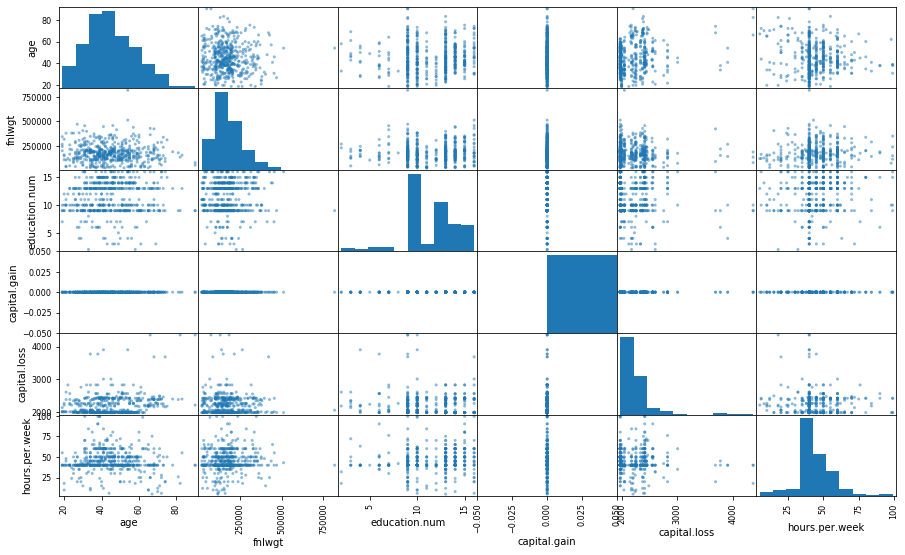

In [1741]:
# Values Distributions
pd.plotting.scatter_matrix(df.head(500), figsize = (15,9), diagonal = 'hist' )
plt.xticks(rotation = 90)

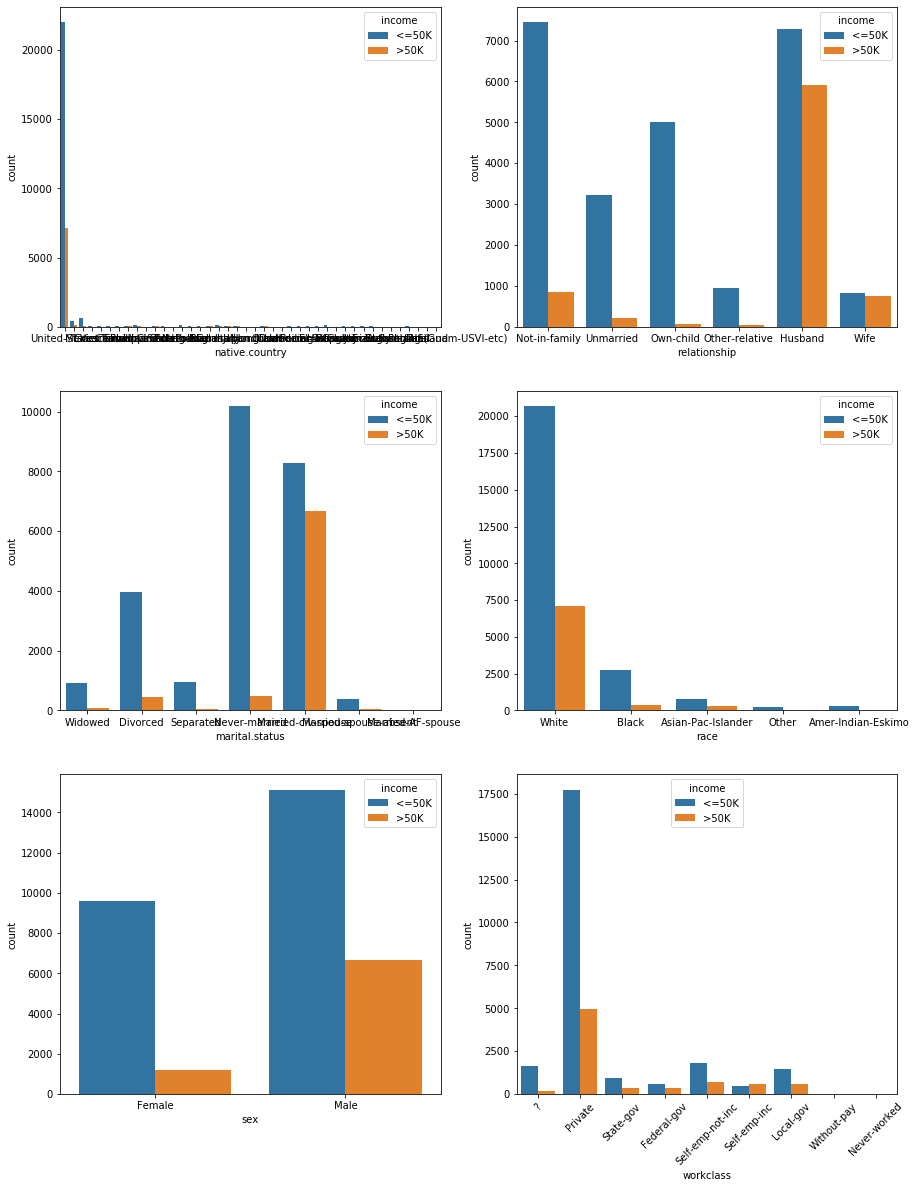

In [1742]:
#Relation of Each Feature with the target
fig, ((a,b),(c,d),(e,f)) = plt.subplots(3,2,figsize=(15,20))
plt.xticks(rotation=45)
sns.countplot(df['workclass'],hue=df['income'],ax=f)
sns.countplot(df['relationship'],hue=df['income'],ax=b)
sns.countplot(df['marital.status'],hue=df['income'],ax=c)
sns.countplot(df['race'],hue=df['income'],ax=d)
sns.countplot(df['sex'],hue=df['income'],ax=e)
sns.countplot(df['native.country'],hue=df['income'],ax=a)

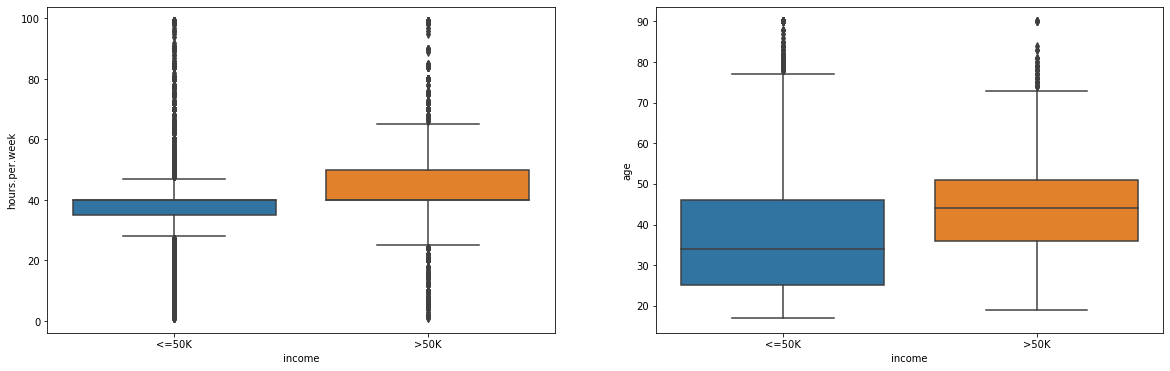

In [1743]:
#Relation of Each Feature with the target
fig, (a,b)= plt.subplots(1,2,figsize=(20,6))
sns.boxplot(y='hours.per.week',x='income',data=df,ax=a)
sns.boxplot(y='age',x='income',data=df,ax=b)

In [1744]:
#additional operations to manipulate data and see it through different perspectives

#df.sort_values(['age','fnlwgt'], ascending = False).head(20)
#df.groupby(df.age).count().plot(kind = 'bar')
#df.groupby('age')['fnlwgt'].mean().sort_values(ascending = False).head(10)
#pd.crosstab(df.age, df.fnlwgt).apply(lambda x: x/x.sum(), axis=1)
#df['young_male'] = ((df.fnlwgt == '19302') & (df.age < 30)).map({True: 'young male', False: 'other'})
#display(df['young_male'])

# Data Pre-Processing


## Nonsense values
Negative Values, etc

In [1745]:
pd.set_option('display.max_columns', 100)
for col in df:
    print(col)
    print (df[col].unique())
    print('\n')


age
[90 82 66 54 41 34 38 74 68 45 52 32 51 46 57 22 37 29 61 21 33 49 23 59
 60 63 53 44 43 71 48 73 67 40 50 42 39 55 47 31 58 62 36 72 78 83 26 70
 27 35 81 65 25 28 56 69 20 30 24 64 75 19 77 80 18 17 76 79 88 84 85 86
 87]


workclass
['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']


fnlwgt
[ 77053 132870 186061 ...  34066  84661 257302]


education
['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']


education.num
[ 9 10  4  6 16 15 13 14  7 12 11  2  3  8  5  1]


marital.status
['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']


occupation
['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service' 'Adm-clerical' 'Craft-repair' 'Transport-moving'
 'Handlers-cleaners' 'Sales' 'Farming-fishing' 'Tech-support'
 

In [1746]:
display(df.describe(include = 'all')) #it helps to understand non-sense values

age workclass        fnlwgt education  education.num  \
count   32561.000000     32561  3.256100e+04     32561   32561.000000   
unique           NaN         9           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     22696           NaN     10501            NaN   
mean       38.581647       NaN  1.897784e+05       NaN      10.080679   
std        13.640433       NaN  1.055500e+05       NaN       2.572720   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%        28.000000       NaN  1.178270e+05       NaN       9.000000   
50%        37.000000       NaN  1.783560e+05       NaN      10.000000   
75%        48.000000       NaN  2.370510e+05       NaN      12.000000   
max        90.000000       NaN  1.484705e+06       NaN      16.000000   

            marital.status      occupation relationship   race    sex  \
count                32561           32561        32561  32561  32561   
unique                   7              15            6      5      2   
top     Married-civ-spouse  Prof-specialty      Husband  White   Male   
freq                 14976            4140        13193  27816  21790   
mean                   NaN             NaN          NaN    NaN    NaN   
std                    NaN             NaN          NaN    NaN    NaN   
min                    NaN             NaN          NaN    NaN    NaN   
25%                    NaN             NaN          NaN    NaN    NaN   
50%                    NaN             NaN          NaN    NaN    NaN   
75%                    NaN             NaN          NaN    NaN    NaN   
max                    NaN             NaN          NaN    NaN    NaN   

        capital.gain  capital.loss  hours.per.week native.country income  
count   32561.000000  32561.000000    32561.000000          32561  32561  
unique           NaN           NaN             NaN             42      2  
top              NaN           NaN             NaN  United-States  <=50K  
freq             NaN           NaN             NaN          29170  24720  
mean     1077.648844     87.303830       40.437456            NaN    NaN  
std      7385.292085    402.960219       12.347429            NaN    NaN  
min         0.000000      0.000000        1.000000            NaN    NaN  
25%         0.000000      0.000000       40.000000            NaN    NaN  
50%         0.000000      0.000000       40.000000            NaN    NaN  
75%         0.000000      0.000000       45.000000            NaN    NaN  
max     99999.000000   4356.000000       99.000000            NaN    NaN

In [1747]:
#CHECK FOR NEGATIVE VALUES BY COLORING THEM
def color_negative_red(val):
    color = 'red' if val <= 0 else 'black'
    return 'color: %s' % color

test = df[['age','capital.gain', 'capital.loss', 'education.num', 'fnlwgt']]
colored = test.head().style.applymap(color_negative_red)

display(colored)

## Missing Values


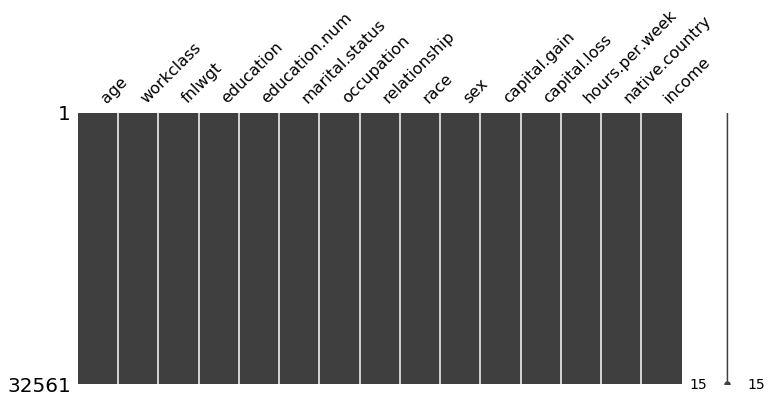

In [1748]:
missingno.matrix(df, figsize=(12, 5))

In [1749]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [1750]:
#convert '?' to NaN
df[df == '?'] = np.nan

#fill the NaN values with the mode. It could be filled with median, mean, etc
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

display(df.head())    

#we could fill every missing values with medians of the columns
#df = data.fillna(df.median())

#also, instead of fill, we can remove every row in which 10% of the values are missing
# df = df.loc[df.isnull().mean(axis=1) < 0.1]    

"""
#It is possible to use an imputer. and fill with the values of median, mean, etc
#If imputation technique is used, it is a good practice to add an additional binary feature as a missing indicator.
imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan,  add_indicator=True)
imputer = SimpleImputer(strategy='mean')
imputer = SimpleImputer(strategy='median')
imputer = SimpleImputer(strategy='constant')
df = pd.DataFrame(imputer.fit_transform(df))
"""

"""
# It is also possible to run a bivariate imputer (iterative imputer). However, it is needed to do labelencoding first. The code below enables us to run the imputer with a Random Forest estimator
# The Iterative Imputer is developed by Scikit-Learn and models each feature with missing values as a function of other features. It uses that as an estimate for imputation. At each step, a feature is selected as output y and all other features are treated as inputs X. A regressor is then fitted on X and y and used to predict the missing values of y. This is done for each feature and repeated for several imputation rounds.
# The great thing about this method is that it allows you to use an estimator of your choosing. I used a RandomForestRegressor to mimic the behavior of the frequently used missForest in R.
imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)
df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)

#If you have sufficient data, then it might be an attractive option to simply delete samples with missing data. However, keep in mind that it could create bias in your data. Perhaps the missing data follows a pattern that you miss out on.

#The Iterative Imputer allows for different estimators to be used. After some testing, I found out that you can even use Catboost as an estimator! Unfortunately, LightGBM and XGBoost do not work since their random state names differ.
"""

age workclass  fnlwgt     education  education.num marital.status  \
0   90   Private   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66   Private  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0     Prof-specialty  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2     Prof-specialty      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K

'\n# It is also possible to run a bivariate imputer (iterative imputer). However, it is needed to do labelencoding first. The code below enables us to run the imputer with a Random Forest estimator\n# The Iterative Imputer is developed by Scikit-Learn and models each feature with missing values as a function of other features. It uses that as an estimate for imputation. At each step, a feature is selected as output y and all other features are treated as inputs X. A regressor is then fitted on X and y and used to predict the missing values of y. This is done for each feature and repeated for several imputation rounds.\n# The great thing about this method is that it allows you to use an estimator of your choosing. I used a RandomForestRegressor to mimic the behavior of the frequently used missForest in R.\nimp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)\ndf = pd.DataFrame(imp.fit_transform(df), columns=df.columns)\n\n#If you have sufficient data, then it mig

(more examples of operations for replacing values if needed in the future)

In [1751]:
"""
#Replace specific values if needed
Replace symbol in whole column
df['age'] = df['age'].str.replace('–', '**', regex = True)


#DROP multiple columns
df.drop(['age' , 'fnlwgt'], axis = 1, inplace = True)


#Find text with regex and replace with nothing
 df = df.replace({
     'age':'[A-Za-z]', 
     'fnlwgt': '[A-Za-z]',
 },'',regex = True)


#Example of applying a formula to entire column

 def euro(cell):
     cell = cell.strip('€')
     return cell
 df.Wage = df.Wage.apply(euro)

#Insert value in cell depending on values from other cells
 def impute_age(cols):
     age = cols[0]
     Pclass = cols[1]
     if pd.isnull(Age):
         if Pclass == 1:
             return 37
         else:
             return 24
     else:
         return Age
         
#CHANGING DATA TYPES
#changing values to float
df[['Value','Wage','Age']].apply(pd.to_numeric, errors = 'coerce')
df.column.astype(float)
df.dtypes
"""

"\n#Replace specific values if needed\nReplace symbol in whole column\ndf['age'] = df['age'].str.replace('–', '**', regex = True)\n\n\n#DROP multiple columns\ndf.drop(['age' , 'fnlwgt'], axis = 1, inplace = True)\n\n\n#Find text with regex and replace with nothing\n df = df.replace({\n     'age':'[A-Za-z]', \n     'fnlwgt': '[A-Za-z]',\n },'',regex = True)\n\n\n#Example of applying a formula to entire column\n\n def euro(cell):\n     cell = cell.strip('€')\n     return cell\n df.Wage = df.Wage.apply(euro)\n\n#Insert value in cell depending on values from other cells\n def impute_age(cols):\n     age = cols[0]\n     Pclass = cols[1]\n     if pd.isnull(Age):\n         if Pclass == 1:\n             return 37\n         else:\n             return 24\n     else:\n         return Age\n         \n#CHANGING DATA TYPES\n#changing values to float\ndf[['Value','Wage','Age']].apply(pd.to_numeric, errors = 'coerce')\ndf.column.astype(float)\ndf.dtypes\n"

## Duplicates
We can confidently remove duplicates now, because when we'll do the oversampling we we'll use the Smote method that won't generate more duplicates (in contrast to RandomOverSampling). Also, by doing this before the oversampling, we are guaranteeing that we'll have exactly 50%-50% of y-labels balance later.

In [1752]:
print(df.duplicated().sum()) #check if there are duplicates
df.drop_duplicates(keep = 'first', inplace = True) #get rid of them

24


## Feature Transformation/Creation
- Feature Transformation (Modidy existing features) -> Scaling, normalize, standarize, logarithim, ...
- Feature Creation (Add useful features) -> Modify to new, Combine features, Cluster some feature, ...

### Label Encoding

In [1753]:
categorical = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
numerical = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

In [1754]:
#using labelencoder
le = LabelEncoder()
for feature in categorical:
        df[feature] = le.fit_transform(df[feature])

## Finding Outliers

We can detect outliers in 3 ways:

- Standard Deviation
- Percentiles (Tukey method)
- Isolation Forest or LocalOutlierFactor (more appropriate for Anomaly/Fraud Detection Problems)

Then, we can handle them by:
 - Remove them
 - Change them to max/min limit
 
The definition of outlier is quite dubious, but we can defined them as those values that surpasse the limit of 1.5 * IQR.
In this case, either the standard deviation method or Tukey method are valid options. We just need to try and see which gives better results (if it produces better results at all).

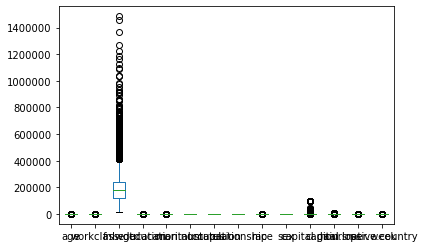

In [1756]:
#See outliers through boxplots
df.plot(kind = 'box', sharex = False, sharey = False)
plt.show()

In [1757]:
# Tukey Method

n = 2 #In this case, we considered outliers as rows that have at least two outlied numerical values. The optimal value for this parameter can be later determined though the cross-validation
indexes = []

for col in df.columns[0:14]:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col],75)
    IQR = Q3 - Q1

    limit = 1.5 * IQR

    list_outliers = df[(df[col] < Q1 - limit) | (df[col] > Q3 + limit )].index # Determine a list of indices of outliers for feature col

    indexes.extend(list_outliers) # append the found outlier indices for col to the list of outlier indices 

indexes = Counter(indexes)        
multiple_outliers = list( k for k, v in indexes.items() if v > n )

df.drop(multiple_outliers, axis = 0)

df = df.drop(multiple_outliers, axis = 0).reset_index(drop=True)
print(str(len(multiple_outliers)) + " outliers were eliminated")

2499 outliers were eliminated


In [1758]:
#You can try with this method to see if it provides better results
"""
#Setting the min/max to outliers using standard deviation
for col in df.columns[0:14]:
    factor = 3 #The optimal value for this parameter can be later determined though the cross-validation
    upper_lim = df[col].mean () + df[col].std () * factor
    lower_lim = df[col].mean () - df[col].std () * factor

    df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]
"""

'\n#Setting the min/max to outliers using standard deviation\nfor col in df.columns[0:14]:\n    factor = 3 #The optimal value for this parameter can be later determined though the cross-validation\n    upper_lim = df[col].mean () + df[col].std () * factor\n    lower_lim = df[col].mean () - df[col].std () * factor\n\n    df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]\n'

## Dealing with imbalanced data

income
<=50K    22841
>50K      7197
dtype: int64

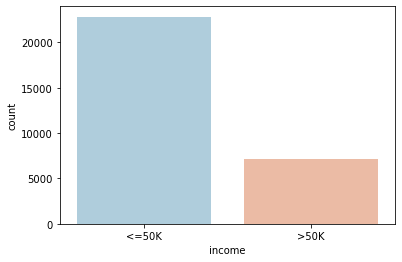

In [1759]:
#Check if there are labels imbalance
sns.countplot(x=df['income'],palette='RdBu_r')
df.groupby('income').size()

In [1760]:
df['income'] = df['income'].map({'>50K': 1, '<=50K': 0})

Y = df['income']
X = df.drop('income',axis=1)

### Oversampling the data **

In [1761]:
# Oversampling using smote 
smk = SMOTETomek(random_state = 42)
X, Y = smk.fit_sample(X, Y)

"""
# RANDOM Oversample #####
os = RandomOverSampler() #ratio of one feature and another is 50% and 50% respectively
X, Y = os.fit_sample(X, Y)
"""

'\n# RANDOM Oversample #####\nos = RandomOverSampler() #ratio of one feature and another is 50% and 50% respectively\nX, Y = os.fit_sample(X, Y)\n'

In [1762]:
#If dowsample was needed...

"""
# RANDOM Undersample #####
os = RandomUnderSampler() #ratio of one feature and another is 50% and 50% respectively
X, Y = os.fit_sample(X, Y)
"""

"""
#Using nearmiss
nm = NearMiss()
X, Y = nm.fit_sample(X, Y)
"""

'\n#Using nearmiss\nnm = NearMiss()\nX, Y = nm.fit_sample(X, Y)\n'

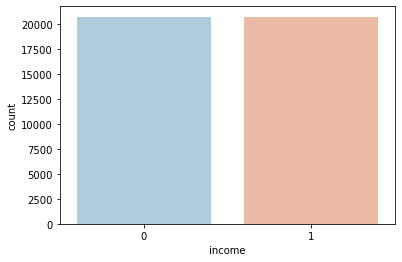

In [1763]:
#making sure that everything is good now
df = pd.concat([X, Y], axis=1)
sns.countplot(x=Y,palette='RdBu_r')

## Transforming Skewed Continuous Features

In [1764]:
def analyze_skew():
    #analyze which features are skewed
    fig = plt.figure(figsize = (15,10))
    cols = 3
    rows = math.ceil(float(df[numerical].shape[1] / cols))
    for i, column in enumerate(numerical):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if df.dtypes[column] == np.object:
            df[column].value_counts().plot(kind = 'bar', axes = ax)
        else:
            df[column].hist(axes = ax)
            plt.xticks(rotation = 'vertical')
    plt.subplots_adjust(hspace = 0.7, wspace = 0.2)
    plt.show()
    
    # from the plots we can see that there are multiple features skewed. However, the following procedure allows us to see in detail how skewed are they.
    skew_feats = df[numerical].skew().sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew': skew_feats})
    
    display(skewness)

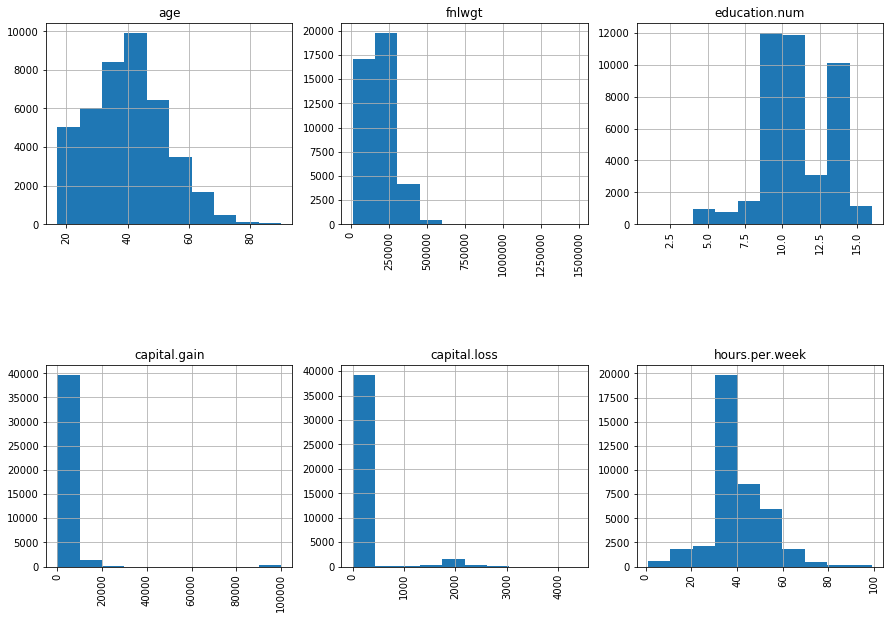

Skew
capital.gain    8.866929
capital.loss    4.138455
fnlwgt          1.277222
age             0.321511
hours.per.week  0.109324
education.num  -0.195546

In [1765]:
analyze_skew()

In [1766]:
#Let's reduce the skew of fnlwgt, capital.gain, capital.loss
skewed = ['fnlwgt', 'capital.gain', 'capital.loss']
features_log_transformed = pd.DataFrame(data=df)
features_log_transformed[skewed] = df[skewed].apply(lambda x: np.log(x + 1)) #it can be other function like polynomial, but generally the log funtion is suitable

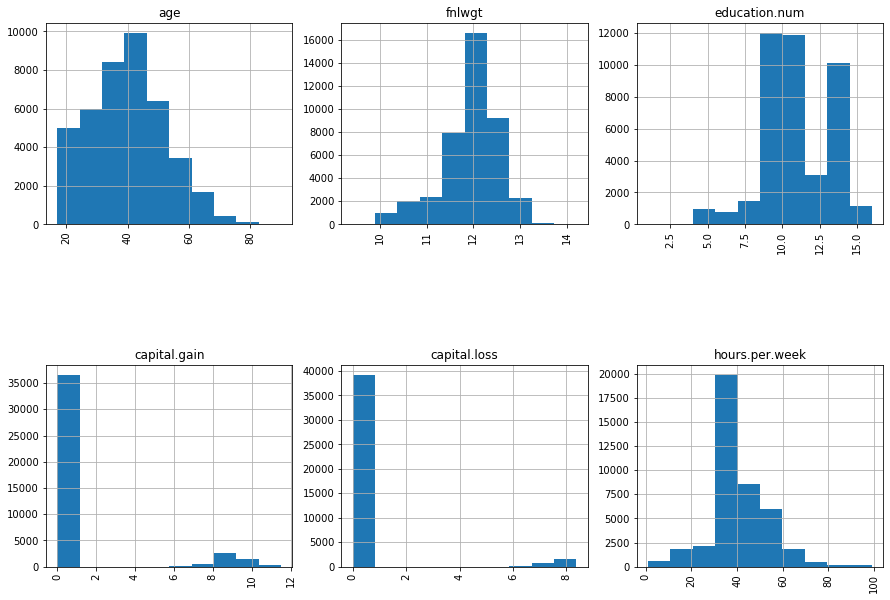

Skew
capital.loss    3.892085
capital.gain    2.407371
age             0.321511
hours.per.week  0.109324
education.num  -0.195546
fnlwgt         -0.905550

In [1767]:
#check again if is everything ok
analyze_skew()

### Binning
Binning continuous variables prevents overfitting which is a common problem for tree based models like decision trees and random forest.

Let's binning the age and see later if the results improved or not. 

Binning with fixed-width intervals (good for uniform distributions). For skewed distributions (not normal), we can use binning adaptive (quantile based).

TO-DO: analyze if binning really improves the model. Include experimenting binning after and before the remove of outliers. Theoretically, if it is a linear mode, and data has a lot of "outliers" binning probability is better. If we have a tree model, then, outlier and binning will make too much difference.

In [1768]:
#Binner adaptive
binner = KBinsDiscretizer(encode='ordinal')
binner.fit(X[['age']])
X['age'] = binner.transform(X[['age']])

"""
#Using fixed-width intervals
age_labels = ['infant','child','teenager','young_adult','adult','old', 'very_old']

ranges = [0,5,12,18,35,60,81,100]

df['age'] = pd.cut(df.age, ranges, labels = age_labels)

"""
#age now becomes a category
categorical = ['age', 'workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
numerical = ['fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

# Feature Selection
- Feature Selection/Reduction (Remove useless features) -> See feature importance, correlations, Dimensionality reduction,

As we only have 14 features, we are not pressured to make a feature selection/reduction in order to increase drastically the computing time of the algorithms. So, for now, we are going to investigate if there are features extremely correlated to each other. After tuning and choosing the best model, we are revisiting feature selection methods just in case we face overfitting or to see if we could achieve the same results with the chosen model but with fewer features.

## Correlation

Since we have a mix of numerical and categorical variables, we are going to analyze the correlation between them independently and then mixed. 

- Numerical & Numerical: Pearson correlation is a good one to use, although there are others.
- Categorical & Categorical: We will make use Chi-squared and uncertainty correlation methods through a library called dython. 
- Numerical & Categorical: We can use point biserial correlation (only if categorical variable is binary type), or ANOVA test.

###
#Simple regression line of various variables in relation to  one other
sns.pairplot(X, x_vars = ['capital.loss', 'hours.per.week', 'education.num'], y_vars = 'age', size = 7, aspect = 0.7, kind = 'reg')

###
# Overview
sns.pairplot(data = X)

**Correlations between numerical features**

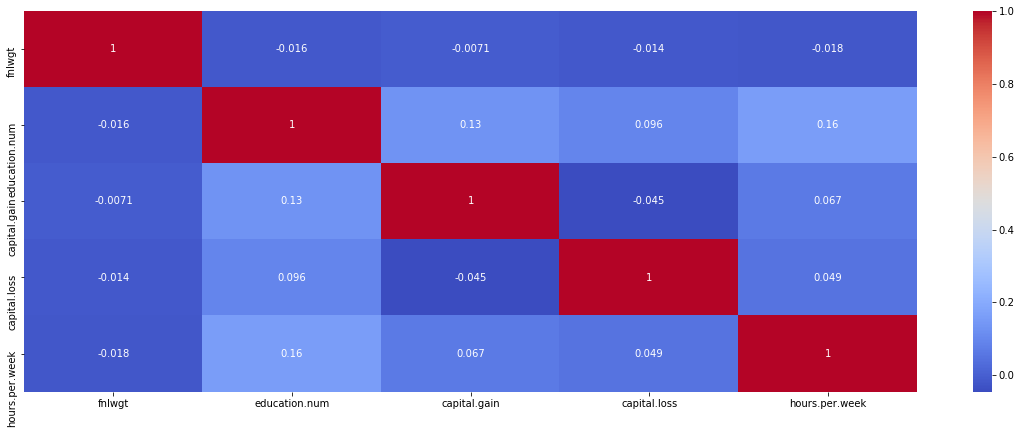

In [1769]:
data = X[X.columns.intersection(numerical)]

plt.subplots(figsize=(20,7))
sns.heatmap(data.corr(method = 'pearson'),annot=True,cmap='coolwarm') # the method can also be 'spearman' or kendall'

#to see the correlation between just two variables
#df['age'].corr(df['capital.gain']) 

**Correlations between categorical features**

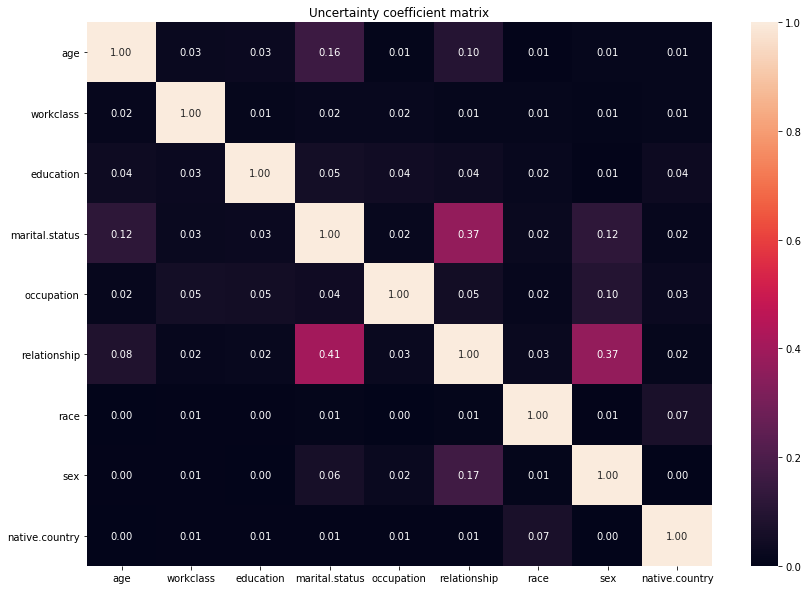

In [1770]:
data = X[X.columns.intersection(categorical)]

cols = data.columns
clen = cols.size

pairings = list(itertools.product(data.columns, repeat=2))
theils_mat = np.reshape([nominal.theils_u(data[p[1]],data[p[0]]) for p in pairings],(clen,clen))
final = pd.DataFrame(theils_mat, index=cols, columns=cols)

fig, ax = plt.subplots(1,1, figsize=(14,10))
sns.heatmap(final,0,1,ax=ax,annot=True,fmt="0.2f").set_title("Uncertainty coefficient matrix")
plt.show()

**Correlations between categorical and numerical features**

In [1771]:
for num_feature in numerical:
    for cat_feature in categorical:
        args_list = []
        for unique in X[cat_feature].unique():
            args_list.append(X[num_feature][X[cat_feature] == unique])
        
        f_val, p_val = st.f_oneway(*args_list) # Calculate f statistics and p value
        print('Anova Result between ' + num_feature, ' & '+ cat_feature, ':' , f_val, p_val)  


Anova Result between fnlwgt  & age : 46.5268912453089 4.4569777829507625e-39
Anova Result between fnlwgt  & workclass : 17.225633165330635 6.288135071856597e-23
Anova Result between fnlwgt  & education : 2.0441905248254884 0.009762901624964735
Anova Result between fnlwgt  & marital.status : 12.765005429527205 1.863796006189575e-14
Anova Result between fnlwgt  & occupation : 4.886910693344456 1.238304197319541e-08
Anova Result between fnlwgt  & relationship : 4.632298851532457 0.000315172576659874
Anova Result between fnlwgt  & race : 124.46697285232068 8.419234664072455e-106
Anova Result between fnlwgt  & sex : 21.376514181262525 3.7850098384784932e-06
Anova Result between fnlwgt  & native.country : 9.016744621966946 6.041379543094484e-53
Anova Result between education.num  & age : 375.3390218104468 4.008967e-318
Anova Result between education.num  & workclass : 182.34501783540682 2.926460563414695e-267
Anova Result between education.num  & education : 5874.925074869358 0.0
Anova Resul

**As the p-values are less than 0.05, there's statistical differences between the means of the features. Also, as we could perceive from the heatmaps, there's no highly correlated features. Down bellow are the procedures to drop the highest correlated features, even though it's not needed in this case or it might even result in worse results. Let's then proceed with PCA and Backward Elimination methods anyway**

## PCA

In [1772]:
#Scalling first a copy of the data
X_copy = X
col_names = X_copy.columns
features = X_copy[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X_copy[col_names] = features

n_comp = len(X_copy.columns)

pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(X_copy)

print('Variance contributions of each feature:')
for j in range(n_comp):
    print(pca.explained_variance_ratio_[j])

Variance contributions of each feature:
0.15333401147860876
0.09017507190925499
0.08077640443554372
0.07919458379640439
0.07488899723544262
0.07208533900204
0.07012768352265898
0.0683329909193502
0.06436520907871121
0.06394355798892185
0.060094930420008276
0.04993640547259082
0.04580411241288386
0.026940702327580213


As we can see, every feature has a meaningful contribution to variance. So there's no need to use PCA-componentes. Anyway, we can render the graph to see how the pca-components data look like.

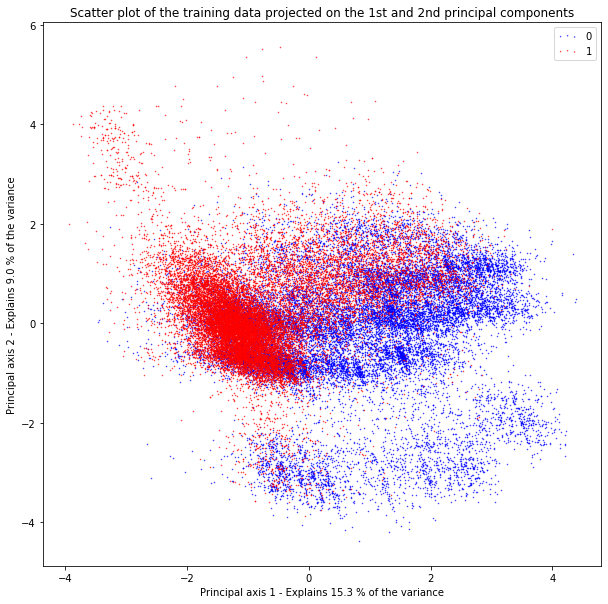

In [1773]:
colors = ['blue', 'red']
plt.figure(1, figsize=(10, 10))

for color, i, target_name in zip(colors, [0, 1], np.unique(Y)):
    plt.scatter(X_pca[Y == i, 0], X_pca[Y == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))



plt.show()

In [1774]:
#Making the feature reduction if it was actually needed
#X = pd.DataFrame(data = pca_train, columns = ['pca-1', 'pca-2'])

## BACKWARD ELIMINATION (wrapper method 1)

- 1) We select a significance level (SL) to stay in the model
- 2) Fit the full model with all possible predictors
- 3) Loop (while p-value < SL)
    - 4) Consider the predictor with highest p-value. 
    - 5) Remove the predictor
    - 6) Fit model without this variable
    
So basically we are feeding all the possible features to the model and then proceed to iteratively remove 
the worst performing features one by one. The metric to evaluate feature performance is pvalue above 0.05 (to keep the feature).

In [1775]:
pmax = 1
SL = 0.05 # the smaller the SL, the more features will be removed
cols = list(X.columns)
while (len(X.columns) > 0):
    
    p_values = []
    
    Xtemp = X[cols]
    Xtemp = sm.add_constant(Xtemp)
    model = sm.OLS(Y,Xtemp).fit()
    
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    p_max = max(p)
    feature_pmax = p.idxmax()
    
    if(p_max > SL):
        cols.remove(feature_pmax)
    else:
        break

print('A total of {} features selected: {}'.format(len(cols), cols))

#to apply feature reduction
#X = X[cols]

A total of 14 features selected: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']


Backward elimination actually tells us that we can eliminate the feature native.country. However, as we have just a few features, we don't have the urge to sacrifice a little bit of the accuracy of the model due to performing speed. In the latter parts of this notebook there are shown more advanced feature selection techniques just in case will be needed in the future.

# Base Line Model

In [1776]:
l=pd.DataFrame(Y)
l['baseline'] = 0
k = pd.DataFrame(confusion_matrix(Y,l['baseline']))
print(k)
print("Accuracy: " + str(accuracy_score(Y, l['baseline'])))

"""
#If we just want to perform OLS regression to find out interesting stats:
X1 = sm.add_constant(X)
model = sm.OLS(Y, X1).fit()
display(model.summary())
print(model.pvalues)
"""

       0  1
0  20756  0
1  20756  0
Accuracy: 0.5


'\n#If we just want to perform OLS regression to find out interesting stats:\nX1 = sm.add_constant(X)\nmodel = sm.OLS(Y, X1).fit()\ndisplay(model.summary())\nprint(model.pvalues)\n'

In [1777]:
#Saving data before OneHotEncoding to assess future importance later
X_not_encoded = copy.deepcopy(X)
X_not_encoded[X.columns] = StandardScaler().fit_transform(X) #not encoded yet, but scaled!

# Constructing the Pipeline

After analyzing the data and all the feature engineering possibilities, methods and what results from them, it is important to build an ML pipeline, i.e, a structure that encodes the sequence of all the transformations needed to each feature. 

This is particularly usefull for making predictions on new data. We want to transform new prediction data futurely to the standard with which our models were trained. 

We couldn't do at first because we had to know first if it would be needed to eliminate outliers or not, it it would be needed to make reduce dimensionality, etc. Those operations can change the number of features left or created when we encode posteriorly.

So, our pipeline will only cover operations that can change the value and number of final features, and not other feature engineering aspects like class imbalance, skewness, outliers, etc.

- 1) We'll revert all the feature transformations absolutely needed to deal with class imbalance, skewness, outliers, pca, etc. For example: to check if a pca was needed, we had to standardize the values; to eliminate outliers, we had to encode the categorical variables before...So, in the end of this, we are able to fit the pipeline with all the data cleaned and with the original structure. 
      - Revert scaler -> binning -> label encoding -> imputer (we want our model to be able to predict new data with missing fields)
- 2) Construct and fit the pipeline with imputer -> label encoding -> binning -> hot encoding -> scaler -> pca

We don't need to aggregate a preferred classifier right now to the pipeline because we will still assess and tune multiple models.

In [1778]:
df_1 = copy.deepcopy(df)
X_1 = copy.deepcopy(X)

#inverse scaling
X_1 = pd.DataFrame(scaler.inverse_transform(X_1))
X_1.columns = df.columns[:-1]

#inverse binning of 'Age'. 
X_1['age'] = binner.inverse_transform(X_1[['age']])

#meanwhile, 'Age' becomes numerical again
#inverse label encoding
for feature in categorical:
    if feature != 'age':
        print(feature)
        X_1[feature] = le.inverse_transform(X_1[feature].astype(int))


#inverse imputer



#confirming that the values were correctly reversed
#havia um registo so de um pais estranho...Holand-Netherlands

"""

all_transformer = Pipeline(steps = [
    #('binning', KBinsDiscretizer(encode='ordinal'))
    #label
    #('pca', pca()) - in our case, reduction of features was not needed
])

numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False))
])


preprocessor = ColumnTransformer(transformers = [
        ('all', all_transformer, df_1.columns)
        #('num', numeric_transformer, numerical),
        #('cat', categorical_transformer, categorical)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


A = pipeline.fit_transform(df_1)
"""

workclass
education
marital.status
occupation
relationship
race
sex
native.country


age workclass    fnlwgt           education  education.num  \
0      70.0  Columbia   77053.0              Greece            9.0   
1      70.0  Columbia  186061.0            Honduras           10.0   
2      70.0  Columbia  140359.0  Dominican-Republic            4.0   
3      39.5  Columbia  264663.0            Honduras           10.0   
4      32.5  Columbia  216864.0              Greece            9.0   
...     ...       ...       ...                 ...            ...   
41507  46.5  Columbia  155489.0               Haiti           11.0   
41508  70.0  Columbia  121013.0  Holand-Netherlands           12.0   
41509  46.5     China  166822.0              France           13.0   
41510  46.5    Canada  293186.0           Guatemala           11.0   
41511  39.5  Columbia  132959.0             Germany            9.0   

           marital.status   occupation relationship      race       sex  \
0                 Ecuador       France       Canada      Cuba  Cambodia   
1                 Ecuador       France         Cuba     China  Cambodia   
2                Cambodia      Ecuador         Cuba      Cuba  Cambodia   
3      Dominican-Republic       France     Columbia      Cuba  Cambodia   
4                Cambodia  El-Salvador         Cuba      Cuba  Cambodia   
...                   ...          ...          ...       ...       ...   
41507               China      Germany     Cambodia      Cuba    Canada   
41508               China       Greece     Cambodia      Cuba    Canada   
41509            Cambodia         Cuba     Columbia  Columbia  Cambodia   
41510               China       France     Cambodia      Cuba    Canada   
41511               China        China     Cambodia      Cuba    Canada   

       capital.gain  capital.loss  hours.per.week native.country  
0     -2.273737e-13        4356.0            40.0  United-States  
1     -2.273737e-13        4356.0            40.0  United-States  
2     -2.273737e-13        3900.0            40.0  United-States  
3     -2.273737e-13        3900.0            40.0  United-States  
4     -2.273737e-13        3770.0            45.0  United-States  
...             ...           ...             ...            ...  
41507 -2.273737e-13           0.0            56.0  United-States  
41508 -2.273737e-13           0.0            17.0  United-States  
41509 -2.273737e-13           0.0            40.0  United-States  
41510 -2.273737e-13           0.0            40.0  United-States  
41511  7.428000e+03           0.0            49.0  United-States  

[41512 rows x 14 columns]

"\n\nall_transformer = Pipeline(steps = [\n    #('binning', KBinsDiscretizer(encode='ordinal'))\n    #label\n    #('pca', pca()) - in our case, reduction of features was not needed\n])\n\nnumeric_transformer = Pipeline(steps = [\n    ('scaler', StandardScaler())\n])\n\ncategorical_transformer = Pipeline(steps = [\n    ('onehot', OneHotEncoder(handle_unknown='ignore')),\n    ('scaler', StandardScaler(with_mean=False))\n])\n\n\npreprocessor = ColumnTransformer(transformers = [\n        ('all', all_transformer, df_1.columns)\n        #('num', numeric_transformer, numerical),\n        #('cat', categorical_transformer, categorical)\n    ])\n\npipeline = Pipeline(steps=[('preprocessor', preprocessor)])\n\n\nA = pipeline.fit_transform(df_1)\n"

# One Hot Encoding

Encoding just the categorical variables and merge them with the numerical data for further standardization.

In [1056]:
encoder = OneHotEncoder(categories="auto")
encoded_feat = pd.DataFrame(encoder.fit_transform(df[categorical]).toarray(), columns=encoder.get_feature_names(categorical))

#concatenate without adding null values -.-''
l1=encoded_feat.values.tolist()
l2=df[numerical].values.tolist()
for i in range(len(l1)):
    l1[i].extend(l2[i])

X=pd.DataFrame(l1,columns=encoded_feat.columns.tolist()+df[numerical].columns.tolist())


# Scaling Normalization

StandardScaler removes the mean and scales the data to unit variance. However, the outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values as shown in the left figure below. Note in particular that because the outliers on each feature have different magnitudes, the spread of the transformed data on each feature is very different: most of the data lie in the [-2, 4] range for the transformed median income feature while the same data is squeezed in the smaller [-0.2, 0.2] range for the transformed number of households.

StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.

MinMaxScaler rescales the data set such that all feature values are in the range [0, 1] as shown in the right panel below. However, this scaling compress all inliers in the narrow range [0, 0.005] for the transformed number of households.

[Source](https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler)

In [1057]:
#Standard
col_names = X.columns

features = X[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X[col_names] = features

In [1058]:
#you can try this one to see if it results in better performances
"""
#Minimax
col_names = X.columns

features = X[col_names]

scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

X[col_names] = features
"""

'\n#Minimax\ncol_names = X.columns\n\nfeatures = X[col_names]\n\nscaler = MinMaxScaler().fit(features.values)\nfeatures = scaler.transform(features.values)\n\nX[col_names] = features\n'

In [1059]:
X_1.shape

(25452, 14)

In [1013]:
X.shape

(25452, 109)

# Split Data

### Shuffle before split

In [675]:
l1=X.values.tolist()
l2=pd.DataFrame(Y).values.tolist()
for i in range(len(l1)):
    l1[i].extend(l2[i])
    
new_df=pd.DataFrame(l1,columns=X.columns.tolist()+pd.DataFrame(Y).columns.tolist())

new_df = shuffle(new_df, random_state=42)

In [676]:
testSize = 0.3 #we can try with different test_sizes

#dividing features that were not hotencoded for frther analysis of the feature importance for each classifier
X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_not_encoded, Y, test_size = 0.2) 

train,test = train_test_split(new_df,test_size=testSize)

y_train = train['income']
X_train = train.drop('income',axis=1)
y_test = test['income']
X_test = test.drop('income',axis=1)

# Building Classifiers and Finding their Best Parameters
Just tuning the crutial parameters, not all of them.
I intercalate between randomizedSearch and GridSearch to diversify

In [476]:
models = []
tree_classifiers = [] #useful to analyze SHAP values later
###tuning_num_folds = 5
tuning_num_folds = 2
jobs=4
num_random_state=10
scoring_criteria='accuracy'
predictions = pd.DataFrame()

In [477]:
def permutation_importance(fittted_model, XTest, YTest):

    perm_model = PermutationImportance(fittted_model, random_state = num_random_state, cv = 'prefit', scoring="accuracy")
    perm_model.fit(XTest, YTest, scoring="accuracy")
    
    display(show_weights(perm_model, feature_names = list(XTest.columns)))

## Random Forest Tuning

In [478]:
name = 'Random Forest'
params ={
             'max_depth': st.randint(3, 11),
            'n_estimators': [50,100,250]
            }

""" #due to lack of computational power, the parameters supposed to tune were diminished
params ={
             'max_depth': st.randint(3, 11),
            'n_estimators': [50,100,150,200,250],
             'max_features':["sqrt", "log2"],
             'max_leaf_nodes':st.randint(6, 10)
            }
            
#remember that the line tunned_model = ... needs to be adjusted depending on the parameters that you include
"""

skf = StratifiedKFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params, scoring='roc_auc', n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

#These two lines are useful to analyze SHAP values later
tree_classifiers.append(('Random Forest', RandomForestClassifier(n_estimators=random_search.best_params_['n_estimators'], max_depth=random_search.best_params_['max_depth'])))
tree_classifiers.append(('Random Forest', RandomForestClassifier(n_estimators=random_search.best_params_['n_estimators'], max_depth=random_search.best_params_['max_depth'])))

model_config_1 = RandomForestClassifier(n_estimators=random_search.best_params_['n_estimators'], max_depth=random_search.best_params_['max_depth'])
model_config_2 = RandomForestClassifier(n_estimators=random_search.best_params_['n_estimators'], max_depth=random_search.best_params_['max_depth'])
tunned_model = model_config_1.fit(X_train,y_train)
models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))    

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   25.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   25.8s finished


## Tuning Logistic Regression

In [479]:
name = 'Logistic Regression'

C_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']
param = {'penalty': penalties, 'C': C_vals}

""" #due to lack of computational power, the parameters supposed to tune were diminished
C_vals = [0.0001, 0.001, 0.01, 0.1,0.13,0.2, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 4.0,4.5,5.0,5.1,5.5,6.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']
param = {'penalty': penalties, 'C': C_vals}

#remember that the line tunned_model = ... needs to be adjusted depending on the parameters that you include
"""

grid = GridSearchCV(LogisticRegression(), param,verbose=False, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = LogisticRegression(penalty=grid.best_params_['penalty'], C=grid.best_params_['C'])
model_config_2 = LogisticRegression(penalty=grid.best_params_['penalty'], C=grid.best_params_['C'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))    

## MLPClassifier tuning




In [480]:
name = 'MLP'

param ={
             'activation':['logistic', 'tanh', 'relu'],
             'learning_rate': ['adaptive'],
}

""" #due to lack of computational power, the parameters supposed to tune were diminished
param ={'max_iter': np.logspace(1, 5, 10).astype("int32"),
             'hidden_layer_sizes': np.logspace(2, 3, 4).astype("int32"),
             'activation':['identity', 'logistic', 'tanh', 'relu'],
             'learning_rate': ['adaptive'],
             'early_stopping': [True],
             'alpha': np.logspace(2, 3, 4).astype("int32")
}

#remember that the line tunned_model = ... needs to be adjusted depending on the parameters that you include
"""

grid = GridSearchCV(MLPClassifier(), param,verbose=True, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = MLPClassifier(activation=grid.best_params_['activation'], learning_rate=grid.best_params_['learning_rate'])
model_config_2 = MLPClassifier(activation=grid.best_params_['activation'], learning_rate=grid.best_params_['learning_rate'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))    

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    1.0s finished


## KNeighborsClassifier tuning

In [481]:
name = 'KNN'
params ={###'n_neighbors': [5, 15,35],
            'n_neighbors': [1],
            'weights':['uniform','distance']
            }

""" #due to lack of computational power, the parameters supposed to tune were diminished
params ={'n_neighbors': st.randint(5,50),
            'weights':['uniform','distance']
            }
}

#remember that the line tunned_model = ... needs to be adjusted depending on the parameters that you include
"""

skf = StratifiedKFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=params, scoring='roc_auc', n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = KNeighborsClassifier(n_neighbors=random_search.best_params_['n_neighbors'], weights=random_search.best_params_['weights'])
model_config_2 = KNeighborsClassifier(n_neighbors=random_search.best_params_['n_neighbors'], weights=random_search.best_params_['weights'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))      

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


## Linear Discriminant tuning

In [482]:
name = 'LDA'

param={'solver': ['svd', 'lsqr', 'eigen']}

grid = GridSearchCV(LinearDiscriminantAnalysis(), param,verbose=True, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = LinearDiscriminantAnalysis(solver=grid.best_params_['solver'])
model_config_2 = LinearDiscriminantAnalysis(solver=grid.best_params_['solver'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))     

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    0.1s finished


## DecisionTreeClassifier tuning

Since each split in the decision tree distinguishes the dependent variable, splits closer to the root, aka starting point, have optimally been determined to have the greatest splitting effect. The feature importance graphic measures how much splitting impact each feature has. It is important to note that this by no means points to causality, but just like in hierarchical clustering, does point to a nebulous groups. Furthermore, for ensemble tree methods, feature impact is aggregated over all the trees.

In [483]:
name = 'DT'
param = {'min_samples_split': [4,7,10,12]}

grid = GridSearchCV(DecisionTreeClassifier(), param,verbose=True, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=10, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=4,
           

In [484]:
"""
# Helper Function to visualize feature importance if needed
plt.rcParams['figure.figsize'] = (8, 4)
predictors = [x for x in X.columns]
def feature_imp(model):
    MO = model.fit(X_train, y_train)
    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
"""


"\n# Helper Function to visualize feature importance if needed\nplt.rcParams['figure.figsize'] = (8, 4)\npredictors = [x for x in X.columns]\ndef feature_imp(model):\n    MO = model.fit(X_train, y_train)\n    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)\n    feat_imp.plot(kind='bar', title='Feature Importances')\n    plt.ylabel('Feature Importance Score')\n"

**Pruning the decision trees**

Adapted from [here](https://stackoverflow.com/questions/49428469/pruning-decision-trees)

In [485]:
"""traverse the tree and remove all children of the nodes with minimum class count less than 5  (or any other condition you can think of)."""
def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)



In [486]:
#These two lines are useful to analyze SHAP values later
tree_classifiers.append(('DT', DecisionTreeClassifier(min_samples_split=grid.best_params_['min_samples_split'])))
tree_classifiers.append(('DT', DecisionTreeClassifier(min_samples_split=grid.best_params_['min_samples_split'])))

model_config_1 = DecisionTreeClassifier(min_samples_split=grid.best_params_['min_samples_split'])
model_config_2 = DecisionTreeClassifier(min_samples_split=grid.best_params_['min_samples_split'])
tunned_model = model_config_1.fit(X_train,y_train)

prune_index(tunned_model.tree_, 0, 5)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))    

## SVC tuning

In [487]:
name = 'SVC'
param={'C':[0.1,0.5, 1,1.3,1.5],
      'kernel': ["linear","rbf"]
      }

""" #due to lack of computational power, the parameters supposed to tune were diminished
param={'C':[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5],
      'kernel': ["linear","rbf"]
      }

#remember that the line tunned_model = ... needs to be adjusted depending on the parameters that you include
"""

grid = GridSearchCV(SVC(), param,verbose=True, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = SVC(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'], probability=True)
model_config_2 = SVC(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'], probability=True)
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))  

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.1s finished


## SGDClassifier tuning

In [488]:
name = 'SGD'
param ={'loss':["log","modified_huber"]} #the other available methods do not enable predict_proba that we need later for roc curves and soft voter

""" #due to lack of computational power, the parameters supposed to tune were diminished
param ={'loss':["log","modified_huber","epsilon_insensitive","squared_epsilon_insensitive"]}

#remember that the line tunned_model = ... needs to be adjusted depending on the parameters that you include
"""

grid = GridSearchCV(SGDClassifier(), param,verbose=False, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = SGDClassifier(loss=grid.best_params_['loss'])
model_config_2 = SGDClassifier(loss=grid.best_params_['loss'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))  

## Boosting

### GradientBoostingClassifier tuning

In [489]:
name = 'GraBoost'
param_grid ={
            'loss': ['deviance', 'exponential'],
            'learning_rate': [0.1, 0.01,0.05,0.001],
            }

""" #due to lack of computational power, the parameters supposed to tune were diminished
param_grid ={'n_estimators': st.randint(100, 800),
            'loss': ['deviance', 'exponential'],
            'learning_rate': [0.1, 0.01,0.05,0.001],
            'max_depth': np.arange(2, 12, 1)}
#remember that the line tunned_model = ... needs to be adjusted depending on the parameters that you include
"""

random_search = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=param_grid, scoring='roc_auc', n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = GradientBoostingClassifier( loss=random_search.best_params_['loss'], learning_rate=random_search.best_params_['learning_rate'], verbose=0)
model_config_2 = GradientBoostingClassifier( loss=random_search.best_params_['loss'], learning_rate=random_search.best_params_['learning_rate'], verbose=0)
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))  

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.4s finished


### AdaBoostClassifier tuning

In [490]:
name = 'AdaBoost'
params ={'n_estimators':st.randint(100, 400),
        'learning_rate':np.arange(.1, 4, .5)}

""" #due to lack of computational power, the parameters supposed to tune were diminished
params ={'n_estimators':st.randint(100, 800),
        'learning_rate':np.arange(.1, 4, .5)}

#remember that the line tunned_model = ... needs to be adjusted depending on the parameters that you include
"""

random_search = RandomizedSearchCV(AdaBoostClassifier(), param_distributions=params, scoring='roc_auc', n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = AdaBoostClassifier(n_estimators=random_search.best_params_['n_estimators'], learning_rate=random_search.best_params_['learning_rate'])
model_config_2 = AdaBoostClassifier(n_estimators=random_search.best_params_['n_estimators'], learning_rate=random_search.best_params_['learning_rate'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))  

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 out of  20 | elapsed:    5.1s remaining:    2.7s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    7.3s finished


### XGBClassifier Tuning

In [491]:
name = 'XGB'
params = {
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [3, 4, 5]
        }

""" #due to lack of computational power, the parameters supposed to tune were diminished
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
#remember that the line tunned_model = ... needs to be adjusted depending on the parameters that you include
"""


skf = StratifiedKFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(XGBClassifier(), param_distributions=params, scoring='roc_auc', n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = XGBClassifier(gamma=random_search.best_params_['gamma'], max_depth=random_search.best_params_['max_depth'], verbose=0)
model_config_2 = XGBClassifier(gamma=random_search.best_params_['gamma'], max_depth=random_search.best_params_['max_depth'], verbose=0)
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))  

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    6.0s finished


In [492]:
name = 'Naive Bayes'
model_config_1 = GaussianNB()
model_config_2 = GaussianNB()
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))  

### CatBoostClassifier Tuning

In [493]:
name = 'CAT'
param = {'iterations': [100, 150], 'learning_rate': [0.3, 0.4, 0.5]}

grid = GridSearchCV(CatBoostClassifier(), param,verbose=True, cv = StratifiedKFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = CatBoostClassifier(iterations=grid.best_params_['iterations'], learning_rate=grid.best_params_['learning_rate'], verbose=0)
model_config_2 = CatBoostClassifier(iterations=grid.best_params_['iterations'], learning_rate=grid.best_params_['learning_rate'], verbose=0)
tunned_model = model_config_1.fit(X_train,y_train, verbose=0)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

###print(name + " - Learning Curve")
###check_fitting(model, name)

#Analyze feature importance of Original Data
###print(name + " - Feature Importances")
###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/' + name + '_model.sav', 'wb'))  

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   46.0s finished


0:	learn: 0.4923273	total: 6.33ms	remaining: 627ms
1:	learn: 0.3100097	total: 11.6ms	remaining: 567ms
2:	learn: 0.2255827	total: 14.8ms	remaining: 480ms
3:	learn: 0.1599955	total: 17.8ms	remaining: 428ms
4:	learn: 0.1334801	total: 28.7ms	remaining: 546ms
5:	learn: 0.1095878	total: 31.9ms	remaining: 499ms
6:	learn: 0.0885438	total: 34.8ms	remaining: 463ms
7:	learn: 0.0807942	total: 41.3ms	remaining: 475ms
8:	learn: 0.0680836	total: 44.3ms	remaining: 447ms
9:	learn: 0.0588956	total: 47.3ms	remaining: 426ms
10:	learn: 0.0521712	total: 50.3ms	remaining: 407ms
11:	learn: 0.0391595	total: 54.8ms	remaining: 402ms
12:	learn: 0.0350633	total: 57.9ms	remaining: 388ms
13:	learn: 0.0312611	total: 61.5ms	remaining: 378ms
14:	learn: 0.0288068	total: 67.4ms	remaining: 382ms
15:	learn: 0.0261593	total: 71.2ms	remaining: 374ms
16:	learn: 0.0233419	total: 74.9ms	remaining: 366ms
17:	learn: 0.0215252	total: 78ms	remaining: 355ms
18:	learn: 0.0201980	total: 80.9ms	remaining: 345ms
19:	learn: 0.0189634	tot

## Ensemble Methods

**Studying Correlation**
If base models' predictions are weakly correlated with each other, the ensemble will likely to perform better. On the other hand, for a strong correlation of predictions among the base models, the ensemble will unlikely to perform better. 

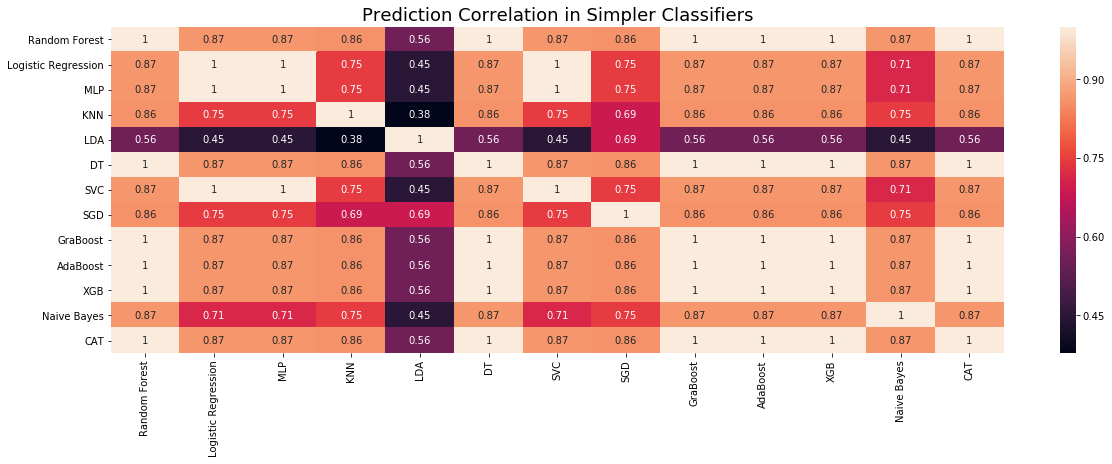

In [494]:
plt.figure(figsize = (20, 6))
correlations = predictions.corr()
sns.heatmap(correlations, annot = True)
plt.title('Prediction Correlation in Simpler Classifiers', fontsize = 18)
plt.show()

**As we can see, there are some classifiers that have a high correlated predictions. So, we won't use them to form the ensemble models.**

In [495]:
classifiers = copy.deepcopy(models)
every_model = copy.deepcopy(models)

for i in range(0, len(correlations.columns)):
    for j in range(0, len(correlations.columns)):
        if j>=i:
            break
        else:
            if abs(correlations.iloc[i,j]) >= 0.85:
                for index, clf in enumerate(classifiers):
                    if correlations.columns[j] == clf[0]:
                        del classifiers[index]
                
classifiers = [i[1] for i in classifiers]

### Voting

Voting can be subdivided into hard voting and soft voting.

Hard voting is purely atributing the majority class from the predictions of all the classifiers.

Soft voting is useful when we have probabilities as output of the classifiers, so we average those values and assume the class that it's close to the probability.

We are going to do just soft voting because it takes into account how certain each voter is, rather than just a binary input from the voter...so, theoretically, it's better.

In [496]:
def soft_voting(average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):
    copy_1 = average_results[average_results.Model.isin([i[0] for i in models])]
    copy_1.sort_values(by=["Test Accuracy"], ascending=False, inplace=True)

    numb_voters = np.arange(2,len(classifiers)+1,1)

    #we we'll try to ensemble the best two classifiers, then the best three, the best, four, etc
    for i in numb_voters:
        models_names = list(copy_1.iloc[0:i,0])
        voting_models = []
        for model1 in models_names:
            for model2 in models:
                if model2[0] == model1:
                    voting_models.append(model2[1])

        model_config_1 = EnsembleVoteClassifier(clfs = voting_models, voting = 'soft') 
        model_config_2 = EnsembleVoteClassifier(clfs = voting_models, voting = 'soft') 
        model = model_config_1.fit(X_train,Y_train)

        name = "SoftVoter_" + str(i) + "_best"
        ###print(name + " - Learning Curve")
        ###check_fitting(model, name)

        #Analyze feature importance of Original Data
        ###print(name + " - Feature Importances")
        ###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)
        
        every_model.append((name, model))
        pickle.dump(model, open('./models/' + name + '_model.sav', 'wb'))
        average_results,models_test_accuracies, models_train_accuracies, models_validation_accuracies = classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies)

    return average_results,models_test_accuracies, models_train_accuracies, models_validation_accuracies

### Bagging (Bootstrapping Aggregation)

Bagging is characteristic of random forest. You bootstrap or subdivide the same training set into multiple subsets or bags. This steps is also called row sampling with replacement. Each of these training bags will feed a mmodel to be trained. After each model being trained, it is time for aggragation, in other orders, to predict the outcome based on a voting system of each model trained.

In [497]:
def bagging(average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):

    random_forest_classifier = RandomForestClassifier() # is the random forest classifier

    model_config_1 = BaggingClassifier(base_estimator = random_forest_classifier, verbose = 0, n_jobs = -1, random_state = seed)
    model_config_2 = BaggingClassifier(base_estimator = random_forest_classifier, verbose = 0, n_jobs = -1, random_state = seed)
    
    model = model_config_1.fit(X_train, Y_train)
    name = "bagging"
    
    ###print(name + " - Learning Curve")
    ###check_fitting(model, name)
    
    #Analyze feature importance of Original Data
    ###print(name + " - Feature Importances")
    ###permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)
    
    every_model.append((name, model))
    pickle.dump(model, open('./models/' + name + '_model.sav', 'wb'))
    
    return classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies)
    
    

### Blending

In [498]:
def blending(average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):
    
    copy_2 = average_results[average_results.Model.isin([i[0] for i in models])]
    copy_2.sort_values(by=["Test Accuracy"], ascending=False, inplace=True)

    numb_voters = np.arange(2,len(classifiers)+1,1)

    #we we'll try to ensemble the best two classifiers, then the best three, the best, four, etc
    for i in numb_voters:
        models_names = list(copy_2.iloc[0:i,0])
        blending_models = []
        for model1 in models_names:
            for model2 in models:
                if model2[0] == model1:
                    blending_models.append(model2[1])

        blend_1 = BlendEnsemble(n_jobs = -1, test_size = 0.5, random_state = seed, scorer="accuracy")
        blend_1.add(blending_models, proba=True) 
        blend_1.add_meta(RandomForestClassifier())

        blend_2 = BlendEnsemble(n_jobs = -1, test_size = 0.5, random_state = seed)
        blend_2.add(blending_models, proba=True) #proba=true s important in order to predict_proba function properly later
        blend_2.add_meta(RandomForestClassifier())

        model = blend_1.fit(X_train, Y_train, scoring="accuracy")
        name = "blending_" + str(i) + "_best"
        
        ###print(name + " - Learning Curve")
        ###check_fitting(model, name)

        #Analyze feature importance of Original Data
        ###print(name + " - Feature Importances")
        ###permutation_importance(blend_2.fit(X_original_train,y_original_train, scoring="accuracy"), X_original_test, y_original_test)
        
        every_model.append((name, model))
        pickle.dump(model, open('./models/' + name + '_model.sav', 'wb'))

        average_results,models_test_accuracies, models_train_accuracies, models_validation_accuracies = classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies)

        
    return average_results,models_test_accuracies, models_train_accuracies, models_validation_accuracies


### Stacking

Shortly, we are trying to fit a model upon Y_valid data and models' predictions (stacked) made during the validation stage. Then, we will try to predict from the models' predictions (stacked) of test data to see if we reach Y_test values.

In this model we can't analyze the true feature importance because all the features that matter are the predictions of the classifiers!

In [499]:
def stacking_function(average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):
    numb_voters = np.arange(2,len(classifiers)+1, 1)

    S_train, S_test = stacking(classifiers, X_train, Y_train, X_test, regression = False, mode = 'oof_pred_bag', needs_proba = False, save_dir = None,metric = accuracy_score, n_folds = num_folds, stratified = True, shuffle = True, random_state =  seed, verbose = 0)                

    super_learner = RandomForestClassifier()
    model_1 = super_learner.fit(S_train, Y_train)
    name = "stacking"
    
    ###print(name + " - Learning Curve")
    ###check_fitting(model, name)
    
    every_model.append((name, model))
    pickle.dump(model, open('./models/' + name + '_model.sav', 'wb'))
    
    return classify_performance(name, model_1, S_train, S_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies)


# Runs
**First of all, we'll execute 30 tests of cross-validation of all the models but with different seeds.**

In [500]:
def check_fitting(model, name):
    
    plt.figure(figsize = (12,8))

    ###number_chunks = 40
    number_chunks = 10
    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, 
                                            train_sizes = np.linspace(0.01, 1.0, number_chunks), cv = 10, scoring = 'accuracy', 
                                            n_jobs = -1, random_state = 0)
    
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)  

    plt.plot(train_sizes, train_mean, '*-', color = 'blue',  label = 'Training score')
    plt.plot(train_sizes, test_mean, '*-', color = 'yellow', label = 'Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha = 0.1, color = 'b') # Alpha controls band transparency.
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha = 0.1, color = 'y')
    
    font_size = 12
    plt.xlabel('Training Set Size', fontsize = font_size)
    plt.ylabel('Accuracy Score', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = 'best')
    plt.grid()
    
    plt.suptitle('Check for Overfitting/Underfitting Issues of ' + name + ' When Submited to Different Training Sizes', fontsize = 15)
    plt.tight_layout(rect = [0, 0.03, 1, 0.97])
    Path("./results/" + name).mkdir(parents=True, exist_ok=True)

    #saving the image
    plt.savefig('./results/' + name + '/learning_curve.png')
    plt.show()

In [501]:
def classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies):
    stratifiedfold = StratifiedShuffleSplit(n_splits=num_folds, random_state=seed)

    cv_results = cross_validate(model, X_train, Y_train, cv=stratifiedfold, scoring=scoring, verbose=0, return_train_score=True)

    print("%s - Train: Accuracy mean - %.3f, Precision: %.3f, Recall: %.3f." % (name, cv_results['train_accuracy'].mean(), cv_results['train_precision'].mean(), cv_results['train_recall'].mean()))
    
    pred_proba = model.predict_proba(X_test)
    if (pred_proba[0].size == 1 ): #just in case that probabilities are not correctly retrieved
        pred_proba = pred_proba.T
    else:
        pred_proba = pred_proba[:, 1]
    
    y_pred =  [round(x) for x in pred_proba]
    
    precision, recall, fscore, support = precision_recall_fscore_support(Y_test, y_pred,average='binary')
    test_accuracy = accuracy_score(Y_test, y_pred)
    
    print("%s - Test: Accuracy - %.3f, Precision: %.3f, Recall: %.3f, F-Score: %.3f" % (name, test_accuracy, precision,recall, fscore))
    
    fpr, tpr, thresholds1 = roc_curve(Y_test, pred_proba)
    pre, rec, thresholds2 = precision_recall_curve(Y_test, pred_proba)
    roc_auc = auc(fpr, tpr)
    
    TP = FP = TN = FN = 0
    for i in range(len(y_pred)): 
        if ((y_pred[i] == 1) and (list(Y_test)[i] == y_pred[i])):
            TP += 1
        if y_pred[i]==1 and list(Y_test)[i]!=y_pred[i]:
            FP += 1
        if y_pred[i]==0 and list(Y_test)[i]==y_pred[i]:
            TN += 1
        if y_pred[i]==0 and list(Y_test)[i]!=y_pred[i]:
            FN += 1
        
    new_entry = {'Model': name,
                 'Test Accuracy': test_accuracy, 
                 'Test Precision': precision, 
                 'Test Recall': recall, 
                 'Test F-Score': fscore, 
                 'AUC': roc_auc,
                 'TPR': tpr,
                 'FPR': fpr,
                 'TP': TP,
                 'FP': FP,
                 'TN': TN,
                 'FN': FN,
                 'Train Accuracy':cv_results['train_accuracy'].mean(), 
                 'Train Precision': cv_results['train_precision'].mean(), 
                 'Train Recall': cv_results['train_recall'].mean(),
                 'Validation Accuracy':cv_results['test_accuracy'].mean(), 
                 'Validation Precision': cv_results['test_precision'].mean(), 
                 'Validation Recall': cv_results['test_recall'].mean(),
                 'PRE': pre,
                 'REC': rec
                }

   
    for key, value in new_entry.items():
        if key != 'Model':
           
            if key == 'TPR' or key == 'FPR' or key == 'PRE' or key =='REC':
                current = average_results.ix[average_results['Model'] == name][key].values
                
                if type(current[0]) == int:
                    average_results.iloc[average_results.ix[average_results['Model'] == name].index.values.astype(int)[0]][key] = value
                else:
                    summed = list(map(add, current[0], list(value)))
                    average_results.iloc[average_results.ix[average_results['Model'] == name].index.values.astype(int)[0]][key] = summed
            else:

                average_results.iloc[average_results.ix[average_results['Model'] == name].index.values.astype(int)[0]][key] = float(average_results.ix[average_results['Model'] == name][key].values) + value
            
            models_test_accuracies.iloc[seed, :][name] = test_accuracy
            models_train_accuracies.iloc[seed, :][name] = cv_results['train_accuracy'].mean()
            models_validation_accuracies.iloc[seed, :][name] = cv_results['test_accuracy'].mean()
            
    return average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies


In [502]:
# RUNNING ALL THE EXPERIMENTS

#### num_experiments = 30
### num_folds = 10
num_experiments = 2
num_folds = 2
scoring = {'accuracy': 'accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro'}


all_models = [i[0] for i in models]

for i in np.arange(2,len(classifiers)+1,1):
              all_models.append("blending_" + str(i) + "_best")

all_models.append("bagging")

for i in np.arange(2,len(classifiers)+1,1):
              all_models.append("SoftVoter_" + str(i) + "_best")

all_models.append("stacking")

models_test_accuracies = pd.DataFrame(columns=all_models)
models_train_accuracies = pd.DataFrame(columns=all_models)
models_validation_accuracies = pd.DataFrame(columns=all_models)

average_results = pd.DataFrame(columns=['Model',
                                        'Test Accuracy',
                                        'Test Precision',
                                        'Test Recall',
                                        'Test F-Score',
                                        'AUC',
                                        'TPR',
                                        'FPR',
                                        'TP',
                                        'FP',
                                        'TN',
                                        'FN',
                                        'Train Accuracy',
                                        'Train Precision',
                                        'Train Recall',
                                        'Validation Accuracy',
                                        'Validation Precision', 
                                        'Validation Recall',
                                        'PRE',
                                        'REC'
                                        ]
                              )

for i, elem in enumerate(all_models):
    average_results = average_results.append(pd.Series(0, index=average_results.columns), ignore_index=True)
    average_results.ix[i,:]['Model'] = elem

for i in range(0, num_experiments):
    print("\n------------------------------- EXPERIMENT " + str(i+1) + " ------------------------------------")
    
    seed = i
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=Y,random_state=seed)
    
    models_train_accuracies = models_train_accuracies.append(pd.Series(0, index=models_train_accuracies.columns), ignore_index=True)
    models_validation_accuracies = models_validation_accuracies.append(pd.Series(0, index=models_validation_accuracies.columns), ignore_index=True)
    models_test_accuracies = models_test_accuracies.append(pd.Series(0, index=models_test_accuracies.columns), ignore_index=True)
    
    #Base Models
    for name, model_2 in models:
        average_results,models_test_accuracies, models_train_accuracies, models_validation_accuracies = classify_performance(name, model_2, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies)
    
    #ensemble models
    average_results,models_test_accuracies, models_train_accuracies, models_validation_accuracies  = bagging(average_results, models_test_accuracies, models_train_accuracies, models_validation_accuracies, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)

    average_results,models_test_accuracies,models_train_accuracies, models_validation_accuracies  = blending(average_results,  models_test_accuracies, models_train_accuracies, models_validation_accuracies, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)

    average_results,models_test_accuracies,models_train_accuracies, models_validation_accuracies  = soft_voting(average_results,  models_test_accuracies, models_train_accuracies, models_validation_accuracies, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)
    
    average_results,models_test_accuracies, models_train_accuracies, models_validation_accuracies  = stacking_function(average_results,  models_test_accuracies, models_train_accuracies, models_validation_accuracies, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)
    


------------------------------- EXPERIMENT 1 ------------------------------------
Random Forest - Train: Accuracy mean - 1.000, Precision: 1.000, Recall: 1.000.
Random Forest - Test: Accuracy - 1.000, Precision: 1.000, Recall: 1.000, F-Score: 1.000
Logistic Regression - Train: Accuracy mean - 1.000, Precision: 1.000, Recall: 1.000.
Logistic Regression - Test: Accuracy - 1.000, Precision: 1.000, Recall: 1.000, F-Score: 1.000
MLP - Train: Accuracy mean - 1.000, Precision: 1.000, Recall: 1.000.
MLP - Test: Accuracy - 1.000, Precision: 1.000, Recall: 1.000, F-Score: 1.000
KNN - Train: Accuracy mean - 1.000, Precision: 1.000, Recall: 1.000.
KNN - Test: Accuracy - 1.000, Precision: 1.000, Recall: 1.000, F-Score: 1.000
LDA - Train: Accuracy mean - 1.000, Precision: 1.000, Recall: 1.000.
LDA - Test: Accuracy - 1.000, Precision: 1.000, Recall: 1.000, F-Score: 1.000
DT - Train: Accuracy mean - 0.966, Precision: 0.969, Recall: 0.964.
DT - Test: Accuracy - 0.909, Precision: 0.833, Recall: 1.000, 

# Analysis of the results

In [503]:
#calculating the average of the metrics
for key, value in enumerate(all_models): 
    for col in average_results.columns:
        if col != 'Model':
            current = average_results.ix[average_results['Model'] == value][col].values
            if col == 'TPR' or col == 'FPR' or col == 'REC' or col == 'PRE':
                division = list(map(truediv, current[0], [num_experiments] *len(current[0])))
            else:
                division = float(current/num_experiments)

            average_results.iloc[average_results.ix[average_results['Model'] == value].index.values.astype(int)[0]][col] = division

In [504]:
#sort by the criteria that you want
average_results.sort_values(by=["Test Accuracy", "Test F-Score","Test Precision", "Test Recall", "AUC"], ascending=False, inplace=True)

display(average_results)

for model in all_models:
    line = pd.DataFrame(columns=average_results.columns)

    line = line.append(pd.Series(average_results.iloc[0, :]), ignore_index=True)
    
    line.to_html('./results/' + model + '/average_results.html')
    imgkit.from_file('./results/' + model + '/average_results.html', './results/' + model + '/average_results.png') # you need to have wkhtmltoimage in your computer  and configure your environmental variable before executing this
    os.remove('./results/' + model + '/average_results.html')

Model Test Accuracy Test Precision Test Recall Test F-Score  \
0         Random Forest             1              1           1            1   
1   Logistic Regression             1              1           1            1   
2                   MLP             1              1           1            1   
3                   KNN             1              1           1            1   
6                   SVC             1              1           1            1   
8              GraBoost             1              1           1            1   
9              AdaBoost             1              1           1            1   
10                  XGB             1              1           1            1   
12                  CAT             1              1           1            1   
15     SoftVoter_2_best             1              1           1            1   
7                   SGD      0.954545       0.928571           1     0.961538   
5                    DT      0.954545       0.916667           1     0.954545   
11          Naive Bayes      0.954545              1         0.9     0.944444   
4                   LDA      0.909091          0.875           1     0.928571   
14              bagging      0.909091          0.875           1     0.928571   
13      blending_2_best      0.909091          0.875           1     0.928571   
16             stacking      0.863636          0.875         0.9     0.873016   

         AUC                                                TPR  \
0          1               [0.0, 0.18333333333333335, 1.0, 1.0]   
1          1               [0.0, 0.18333333333333335, 1.0, 1.0]   
2          1               [0.0, 0.18333333333333335, 1.0, 1.0]   
3          1                                    [0.0, 1.0, 1.0]   
6          1               [0.0, 0.18333333333333335, 1.0, 1.0]   
8          1           [0.0, 0.8166666666666667, 1.0, 1.0, 1.0]   
9          1                          [0.0, 0.9, 1.0, 1.0, 1.0]   
10         1  [0.0, 0.26666666666666666, 0.7333333333333334,...   
12         1               [0.0, 0.18333333333333335, 1.0, 1.0]   
15         1               [0.0, 0.18333333333333335, 1.0, 1.0]   
7       0.95                                    [0.0, 1.0, 1.0]   
5   0.958333                                    [0.0, 1.0, 1.0]   
11      0.95                [0.0, 0.7166666666666667, 0.9, 1.0]   
4          1               [0.0, 0.18333333333333335, 1.0, 1.0]   
14         1               [0.0, 0.18333333333333335, 1.0, 1.0]   
13       0.9                                    [0.0, 1.0, 1.0]   
16       0.9                               [0.0, 0.9, 1.0, 1.0]   

                                          FPR   TP   FP   TN   FN  \
0                        [0.0, 0.0, 0.0, 1.0]  5.5    0  5.5    0   
1                        [0.0, 0.0, 0.0, 1.0]  5.5    0  5.5    0   
2                        [0.0, 0.0, 0.0, 1.0]  5.5    0  5.5    0   
3                             [0.0, 0.0, 1.0]  5.5    0  5.5    0   
6                        [0.0, 0.0, 0.0, 1.0]  5.5    0  5.5    0   
8   [0.0, 0.0, 0.0, 0.2833333333333333, 0.75]  5.5    0  5.5    0   
9   [0.0, 0.0, 0.1, 0.65, 0.9166666666666667]  5.5    0  5.5    0   
10                  [0.0, 0.0, 0.0, 0.0, 1.0]  5.5    0  5.5    0   
12                       [0.0, 0.0, 0.0, 1.0]  5.5    0  5.5    0   
15                       [0.0, 0.0, 0.0, 1.0]  5.5    0  5.5    0   
7                             [0.0, 0.1, 1.0]  5.5  0.5    5    0   
5             [0.0, 0.08333333333333333, 1.0]  5.5  0.5    5    0   
11                       [0.0, 0.0, 0.0, 1.0]    5    0  5.5  0.5   
4                        [0.0, 0.0, 0.0, 1.0]  5.5    1  4.5    0   
14                       [0.0, 0.0, 0.0, 1.0]  5.5    1  4.5    0   
13                            [0.0, 0.2, 1.0]  5.5    1  4.5    0   
16                       [0.0, 0.2, 0.4, 1.0]    5    1  4.5  0.5   

   Train Accuracy Train Precision Train Recall Validation Accuracy  \
0               1               1      

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                    

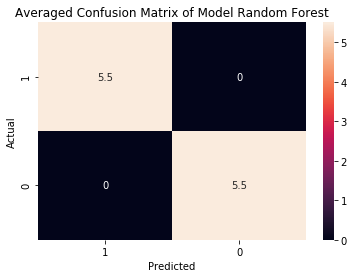

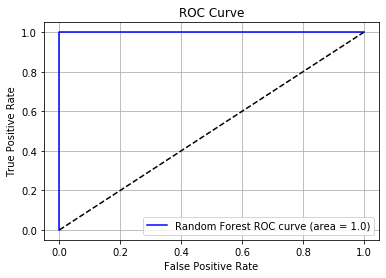

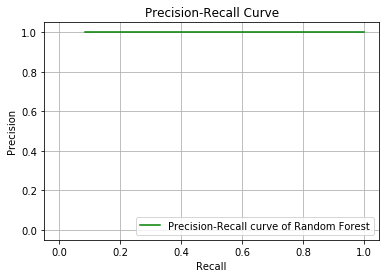

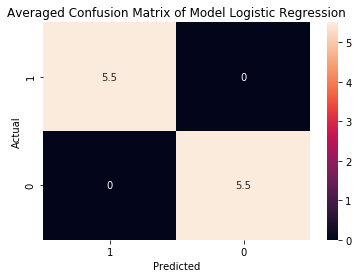

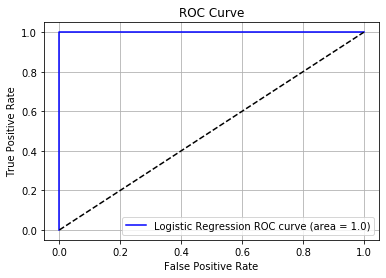

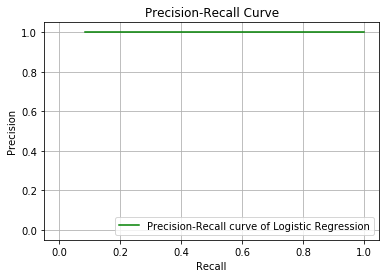

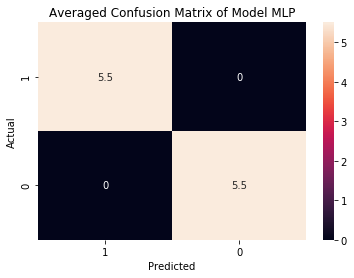

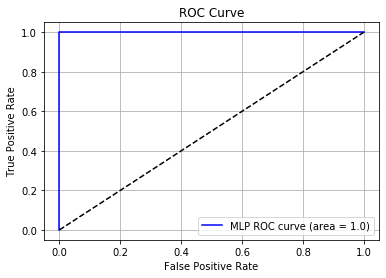

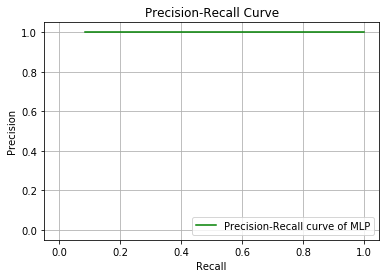

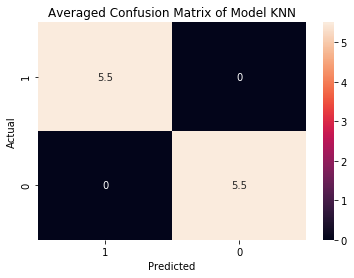

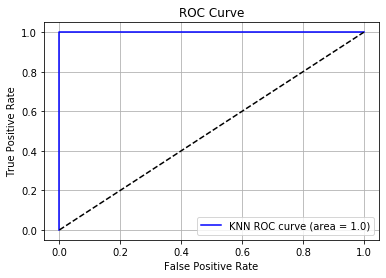

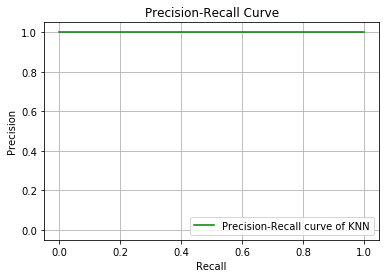

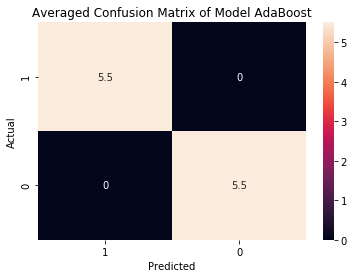

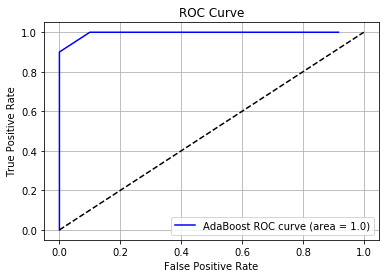

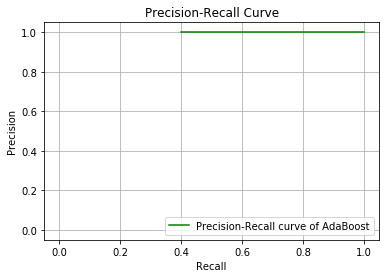

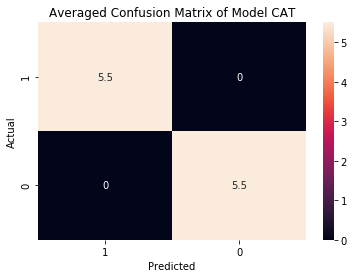

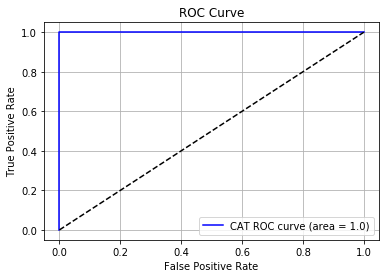

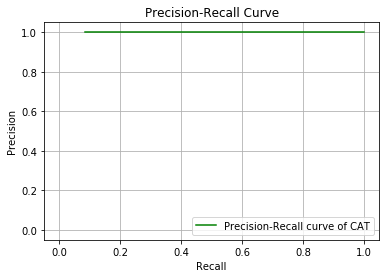

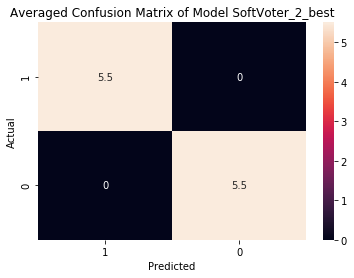

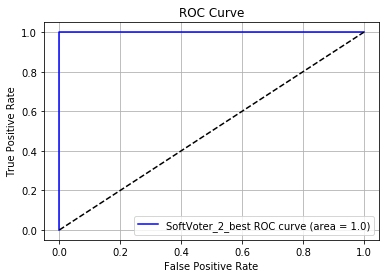

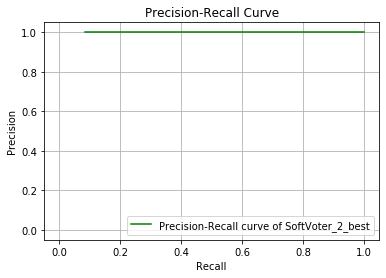

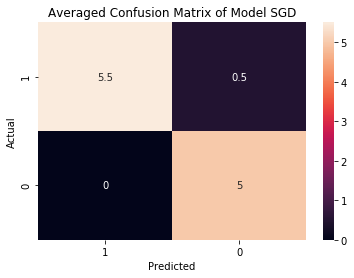

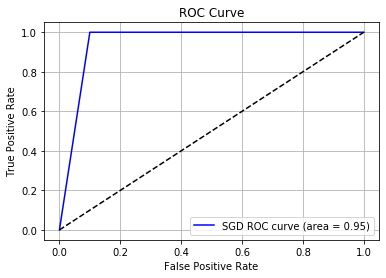

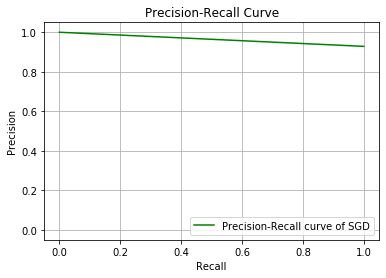

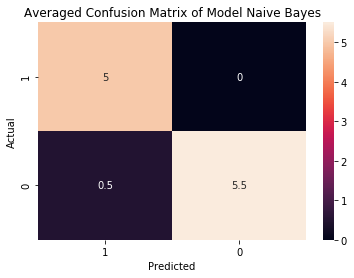

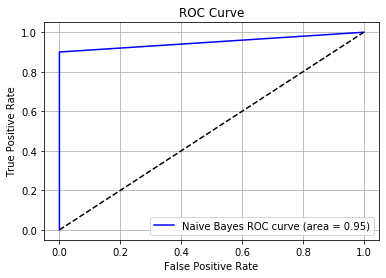

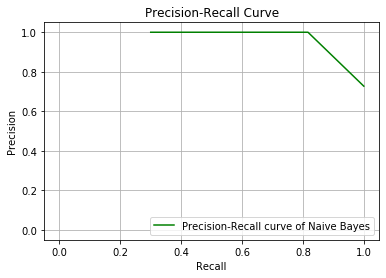

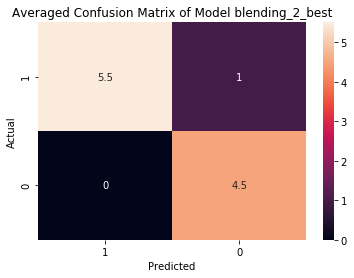

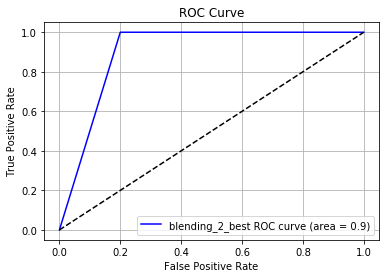

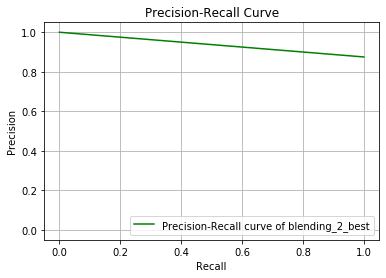

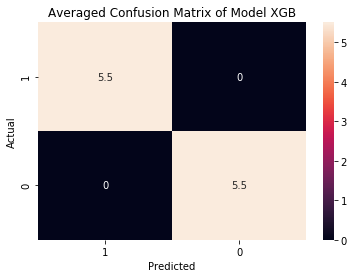

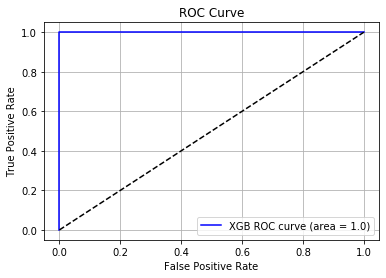

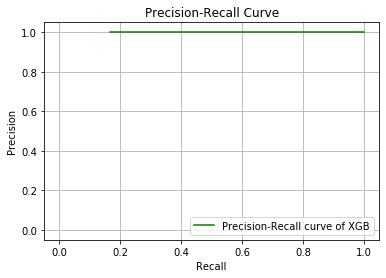

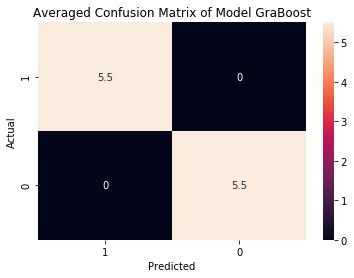

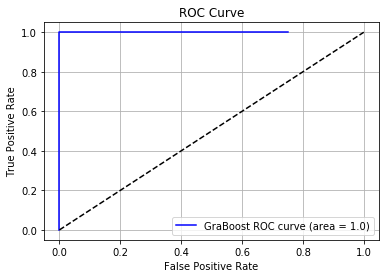

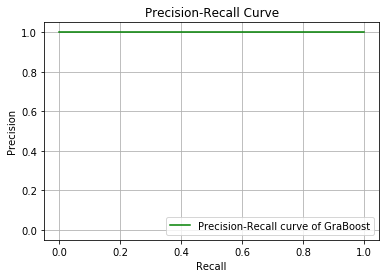

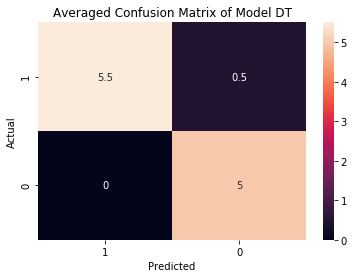

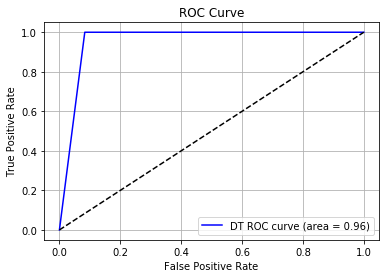

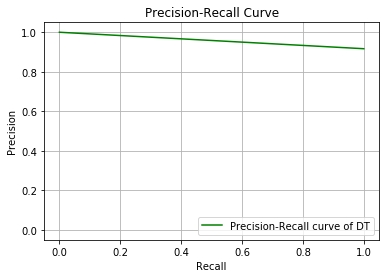

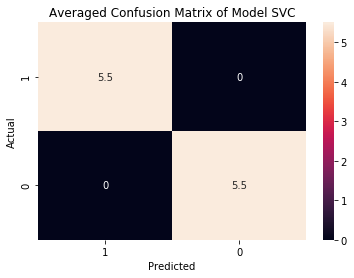

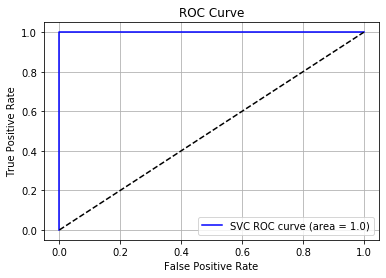

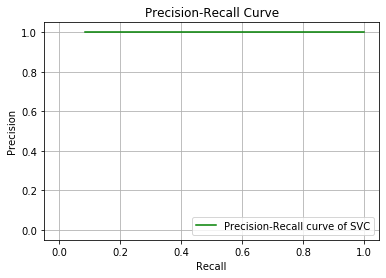

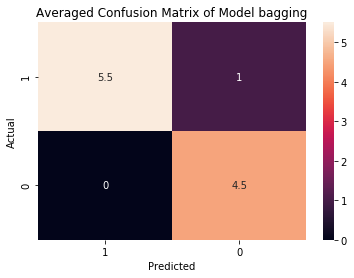

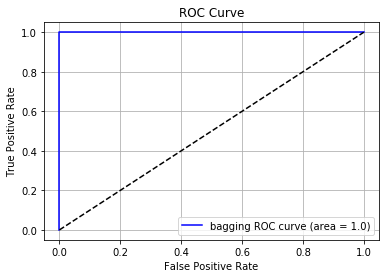

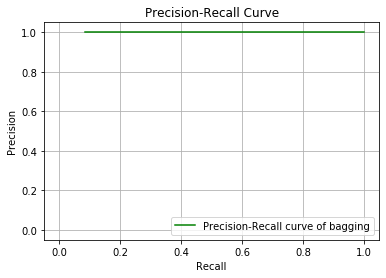

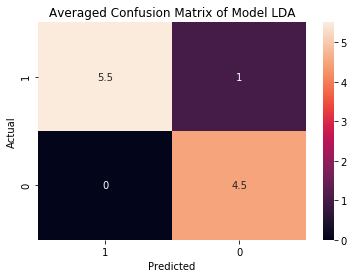

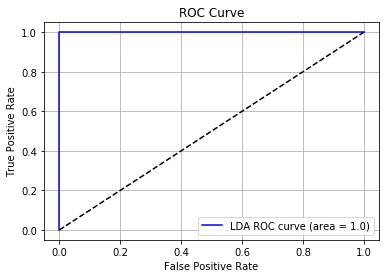

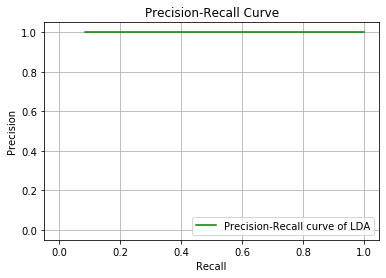

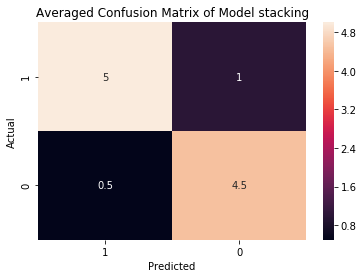

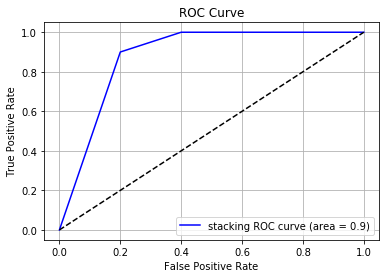

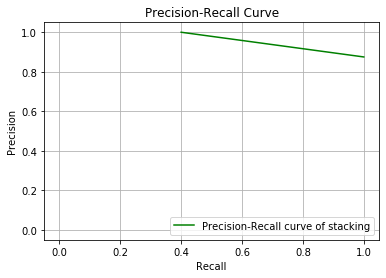

In [505]:
#confusion matrix and roc curves for each algorithm

for index, row in average_results.iterrows():
    
    name = average_results.iloc[index, 0]
    
    tp = average_results.iloc[index, 8]
    fp = average_results.iloc[index, 9]
    tn = average_results.iloc[index, 10]
    fn = average_results.iloc[index, 11]
    
    roc_auc = average_results.iloc[index, 5]
    tpr = average_results.iloc[index, 6]
    fpr = average_results.iloc[index, 7]
    pre = average_results.iloc[index, 18]
    rec = average_results.iloc[index, 19]
    
    confusion_matrix = pd.DataFrame({'1': [tp,  fn],
                                     '0': [fp,  tn]
                                    })

    confusion_matrix.rename(index={0:'1',1:'0'}, inplace=True)

    ax = sns.heatmap(confusion_matrix, annot=True)

    ax.set(xlabel='Predicted', ylabel='Actual')
    plt.title("Averaged Confusion Matrix of Model " + name)
    plt.savefig('./results/' + name + '/confusion_matrix.png')
    plt.show()

    plt.figure(1)
    
    plt.plot(fpr, tpr, color = 'blue', label='{} ROC curve (area = {:.2})'.format(name, roc_auc))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid()
    plt.savefig('./results/' + name + '/roc_curve.png')
    plt.show()
    
    
    plt.plot(rec, pre, color = 'green', label='Precision-Recall curve of {}'.format(name))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig('./results/' + name + '/precision_recall_curve.png')
    plt.show()


my_map = {0: 'Random Forest',
 1: 'Logistic Regression',
 2: 'MLP',
 3: 'KNN',
 4: 'LDA',
 5: 'DT',
 6: 'SVC',
 7: 'SGD',
 8: 'GraBoost',
 9: 'AdaBoost',
 10: 'XGB',
 11: 'Naive Bayes',
 12: 'CAT',
 13: 'blending_2_best',
 14: 'blending_3_best',
 15: 'blending_4_best',
 16: 'blending_5_best',
 17: 'blending_6_best',
 18: 'blending_7_best',
 19: 'blending_8_best',
 20: 'blending_9_best',
 21: 'blending_10_best',
 22: 'blending_11_best',
 23: 'blending_12_best',
 24: 'blending_13_best',
 25: 'bagging',
 26: 'HardVoter_2_best',
 27: 'HardVoter_3_best',
 28: 'HardVoter_4_best',
 29: 'HardVoter_5_best',
 30: 'HardVoter_6_best',
 31: 'HardVoter_7_best',
 32: 'HardVoter_8_best',
 33: 'HardVoter_9_best',
 34: 'HardVoter_10_best',
 35: 'HardVoter_11_best',
 36: 'HardVoter_12_best',
 37: 'stacking'
}

img_name1 = 'all_f_scores'
img_name2 = 'all_accuracies'
dload = os.path.expanduser('~\\Downloads')
save_dir = '.\\results'

#Plot of the average of accuracies of the different algorithms

copy_accuracy = average_results
copy_accuracy.sort_values(by=["Test Accuracy"], ascending=False, inplace=True)
accuracies_sorted = copy_accuracy["Test Accuracy"]
accuracies_sorted.rename(index = my_map,inplace = True) 

cf.go_offline()
init_notebook_mode()


figure = accuracies_sorted.T.iplot(kind = 'bar', asFigure = True, title = 'Average of Accuracies of the Different Algorithms (average of the 30 Experiments)', theme = 'pearl')
iplot(figure,filename=img_name1, image='png')


#Plot of the f-scores of the different algorithms

copy_fscores = average_results
copy_fscores.sort_values(by=["Test F-Score"], ascending=False, inplace=True)
fscores_sorted = copy_fscores["Test F-Score"]
fscores_sorted.rename(index = my_map,inplace = True) 

cf.go_offline()
init_notebook_mode()


figure = fscores_sorted.T.iplot(kind = 'bar', asFigure = True, title = 'F-Scores of the Different Algorithms (average of the 30 Experiments)', theme = 'solar')
iplot(figure,filename=img_name2, image='png')

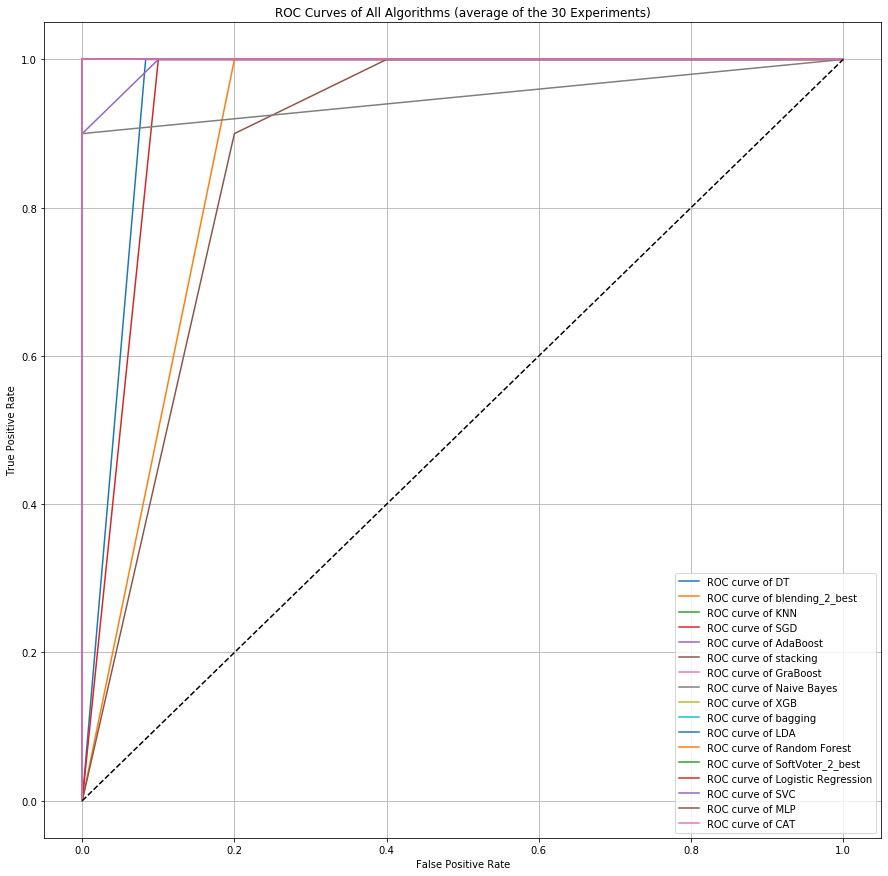

In [506]:
#roc curves of all algorithms overlapped
copy_roc = average_results
copy_roc.sort_values(by=["TPR"], ascending=False, inplace=True)
tprs_sorted = list(copy_roc["TPR"])
fprs_sorted = list(copy_roc["FPR"])
ticks = list(copy_roc["Model"])

fig1 = plt.figure(figsize=(15,15))
for i in range(0, len(fprs_sorted)):
    plt.plot(fprs_sorted[i], tprs_sorted[i], label='ROC curve of {}'.format(ticks[i]))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of All Algorithms (average of the 30 Experiments)')
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], 'k--')
plt.grid()
plt.savefig('./results/all_roc_curve.png')

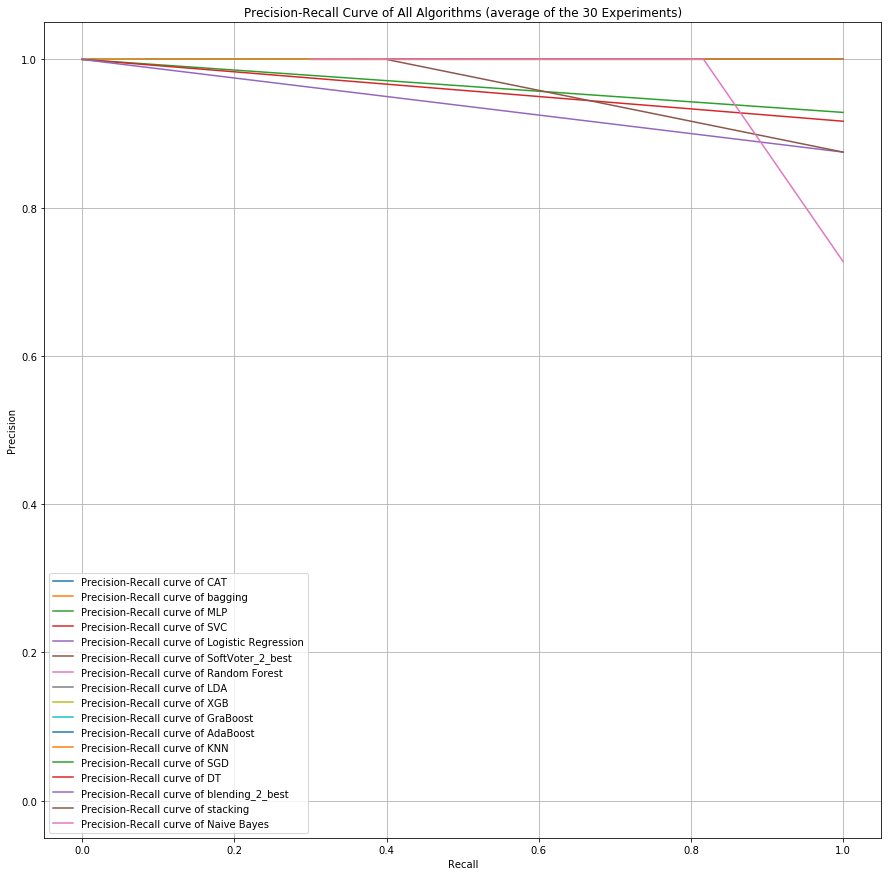

In [507]:
copy_precisionRecall = average_results
copy_precisionRecall.sort_values(by=["PRE"], ascending=False, inplace=True)
precisions_sorted = list(copy_precisionRecall["PRE"])
recalls_sorted = list(copy_precisionRecall["REC"])
ticks = list(copy_precisionRecall["Model"])

fig1 = plt.figure(figsize=(15,15))
for i in range(0, len(recalls_sorted)):
    plt.plot(recalls_sorted[i], precisions_sorted[i], label='Precision-Recall curve of {}'.format(ticks[i]))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of All Algorithms (average of the 30 Experiments)')
plt.legend(loc="lower left")
plt.grid()
plt.savefig('./results/all_precision_recall.png')
plt.show()

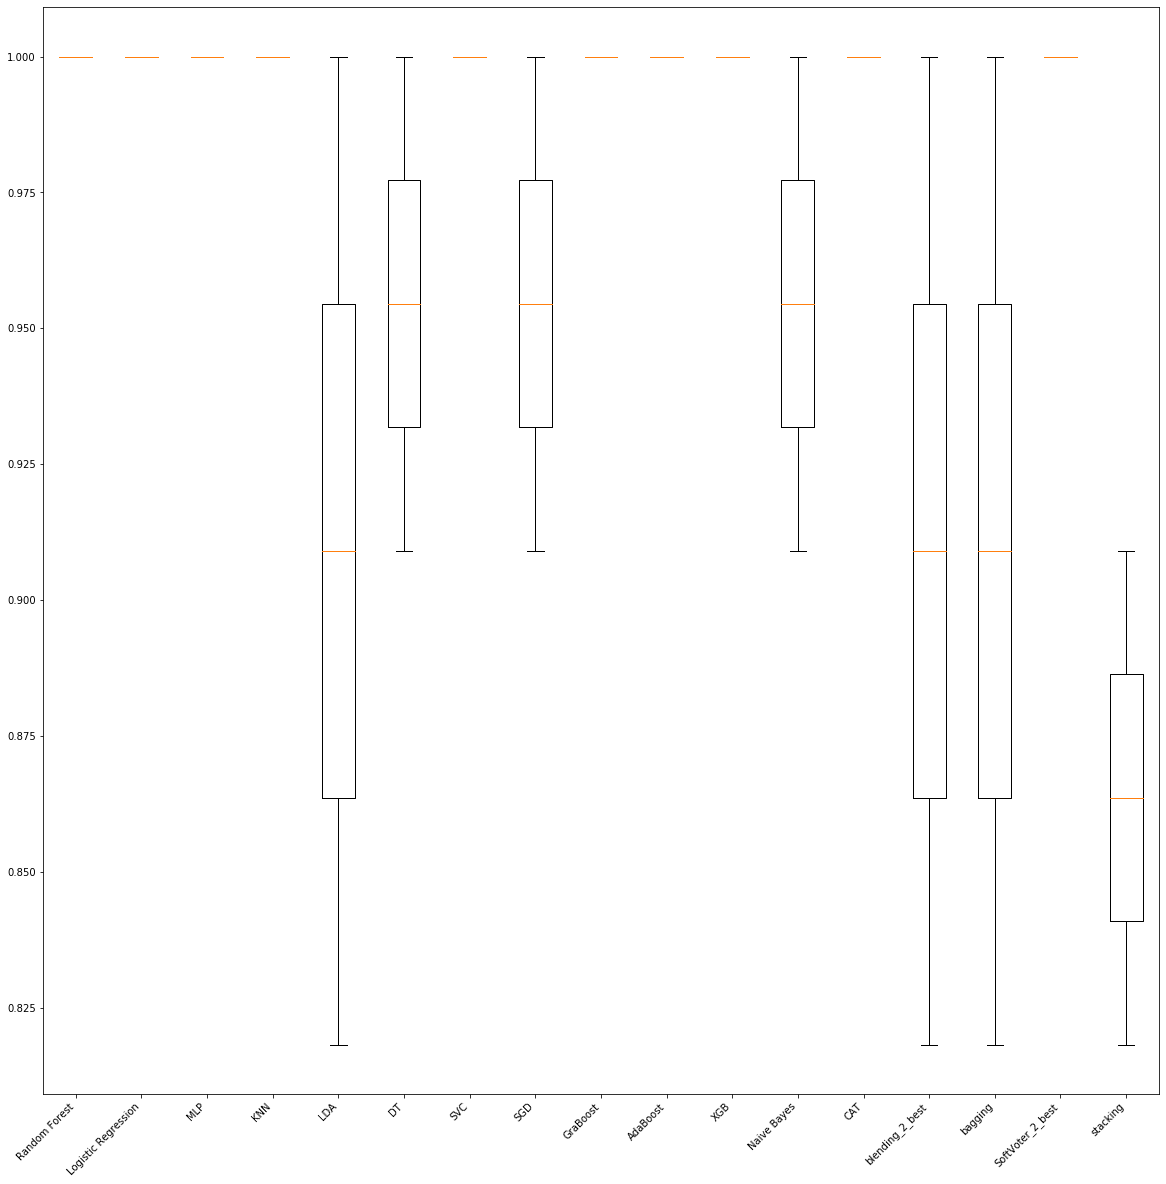

In [508]:
# boxplot algorithm comparison
fig.suptitle('Comparison of the Models Accuracies (average of the 30 Experiments)')

plt.figure(figsize=(20,20))
plt.boxplot(models_test_accuracies.T)
locs, labels=plt.xticks()
x_ticks = []
new_xticks=models_test_accuracies.columns
plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')
plt.savefig('./results/boxplot_accuracies.png')
plt.show()


In [509]:
#saving the plotly images
copyfile('{}\\{}.png'.format(dload, img_name1),
     '{}\\{}.png'.format(save_dir, img_name1))

copyfile('{}\\{}.png'.format(dload, img_name2),
     '{}\\{}.png'.format(save_dir, img_name2))

NameError: name 'dload' is not defined

**Finally, we'll analyze the behavior of validation scores vs training scores vs test scores of each algorithm during the 30 experiments in order to check for overfitting/underfitting issues.**

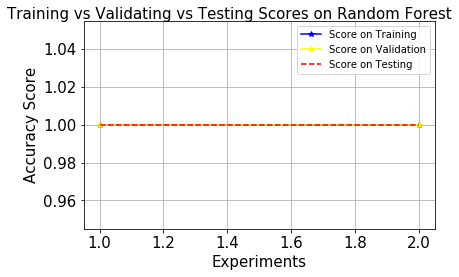

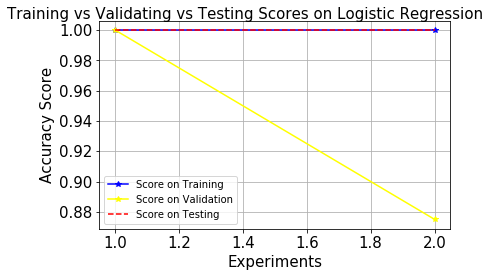

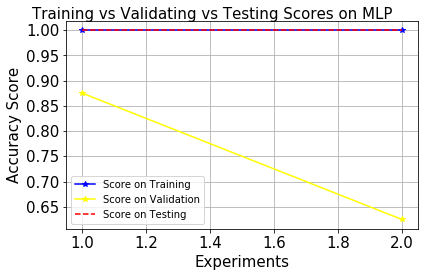

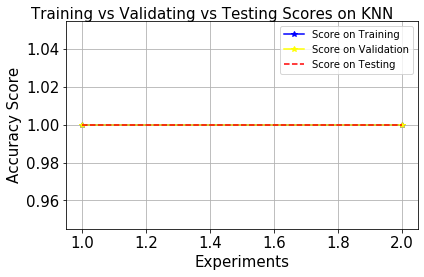

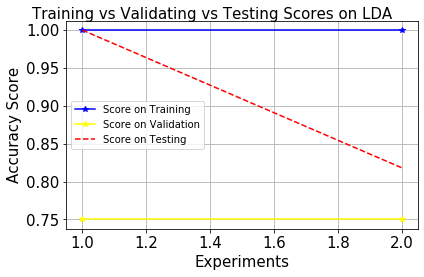

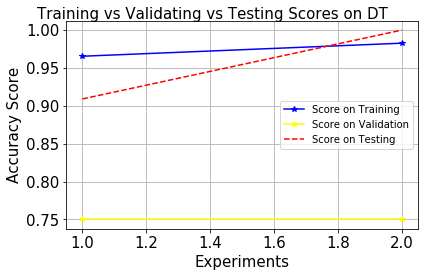

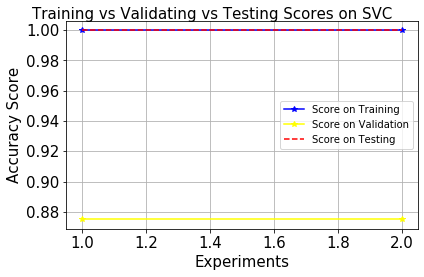

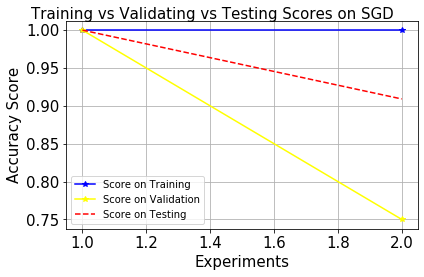

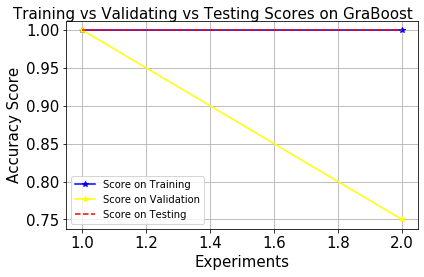

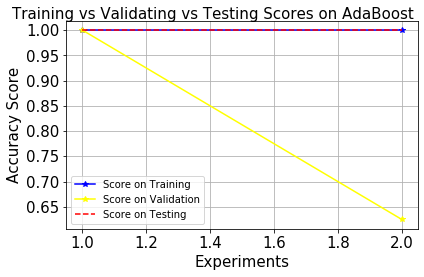

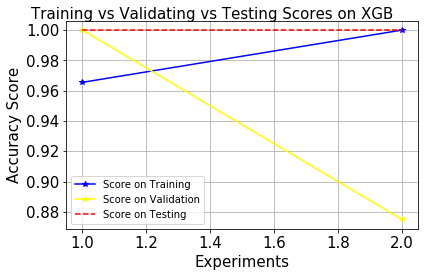

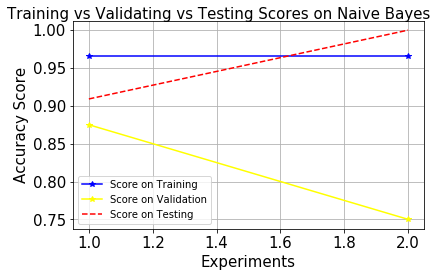

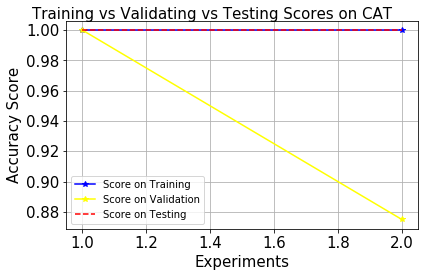

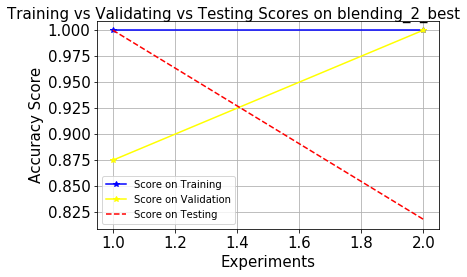

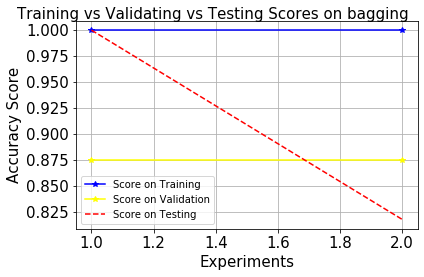

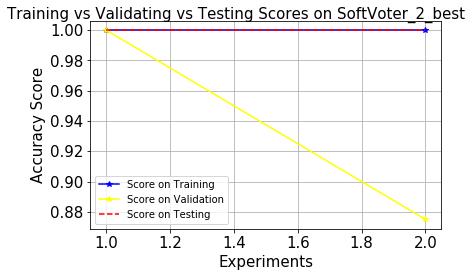

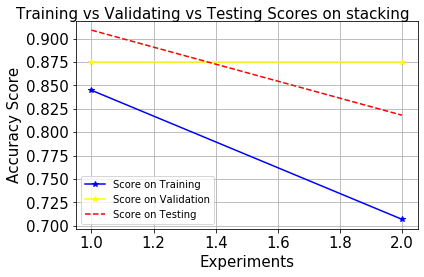

In [510]:
experiments_array = np.arange(1, num_experiments+1, 1)
for model in all_models:
    plt.plot(experiments_array, models_train_accuracies[model].T, '*-', color = 'blue',  label = 'Score on Training')
    plt.plot(experiments_array, models_validation_accuracies[model].T, '*-', color = 'yellow', label = 'Score on Validation')
    plt.plot(experiments_array, models_test_accuracies[model].T, 'r--',  color = 'red', label = 'Score on Testing') 


    font_size = 15
    plt.xlabel('Experiments', fontsize = font_size)
    plt.ylabel('Accuracy Score', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = 'best')
    plt.grid()
    plt.suptitle('Training vs Validating vs Testing Scores on ' + model + '', fontsize = 15)

    plt.tight_layout(rect = [0, 0.03, 1, 0.97])

    plt.savefig('./results/' + name + '/overfitting_underfitting.png')
    plt.show()

# Statistical Tests and Ranking of the Accuracies

- 1) Ranking the results by rows (experiments)
- 2) Friedman test to see if the null hypothesis that the groups of data are similar can be rejected. 
- 3) Nemenyi test to see if that difference is statistical significative.

In [511]:
display(models_test_accuracies)

models_test_accuracies.to_html('./results/models_test_accuracies.html')
imgkit.from_file('./results/models_test_accuracies.html', './results/models_test_accuracies.png') # you need to have wkhtmltoimage in your computer  and configure your environmental variable before executing this
os.remove('./results/models_test_accuracies.html')

Random Forest Logistic Regression MLP KNN       LDA        DT SVC       SGD  \
0             1                   1   1   1         1  0.909091   1         1   
1             1                   1   1   1  0.818182         1   1  0.909091   

  GraBoost AdaBoost XGB Naive Bayes CAT blending_2_best   bagging  \
0        1        1   1    0.909091   1               1         1   
1        1        1   1           1   1        0.818182  0.818182   

  SoftVoter_2_best  stacking  
0                1  0.909091  
1                1  0.818182

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [512]:
#Ranking the results by row (experiment)
###
models_test_accuracies = models_test_accuracies.replace(0,0.0001)
models_test_accuracies_transpose = models_test_accuracies.T

models_test_accuracies_ranked = pd.DataFrame(columns=models_test_accuracies.columns)
for i in models_test_accuracies_transpose:
    models_test_accuracies_ranked = models_test_accuracies_ranked.append(models_test_accuracies_transpose.iloc[:,i].pow(-1).rank(method='dense'), ignore_index=True)
    
temp = models_test_accuracies_ranked.append(models_test_accuracies_ranked.sum(numeric_only=True), ignore_index=True)
temp = temp.sort_values(by=num_experiments, axis=1, ascending=True)

display(temp)

Random Forest  CAT  XGB  AdaBoost  SoftVoter_2_best  SVC  GraBoost  KNN  \
0            1.0  1.0  1.0       1.0               1.0  1.0       1.0  1.0   
1            1.0  1.0  1.0       1.0               1.0  1.0       1.0  1.0   
2            2.0  2.0  2.0       2.0               2.0  2.0       2.0  2.0   

   MLP  Logistic Regression  SGD  Naive Bayes   DT  LDA  blending_2_best  \
0  1.0                  1.0  1.0          2.0  2.0  1.0              1.0   
1  1.0                  1.0  2.0          1.0  1.0  3.0              3.0   
2  2.0                  2.0  3.0          3.0  3.0  4.0              4.0   

   bagging  stacking  
0      1.0       2.0  
1      3.0       3.0  
2      4.0       5.0

In [513]:
# Friedman and nemenyi test
p_values = sp.posthoc_nemenyi_friedman(temp.iloc[0:num_experiments,:])

In [514]:
#Assuming that p = 0.05, we can say that...
with open('./results/statistic_results.txt', 'w') as f:
    for i in range(0, len(p_values.columns)):
        for j in range(0, len(p_values.columns)):
            name1 = p_values.columns[i]
            name2 = p_values.columns[j]
            
            if (j >= i):
                break
            if p_values.iloc[i,j] < 0.01:
                if temp.loc[temp.index[num_experiments], name1] < temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[i] + " is statistically way much better than " + p_values.columns[j], file=f)
                    print("Algorithm " + p_values.columns[i] + " is statistically way much better than " + p_values.columns[j])
                elif temp.loc[temp.index[num_experiments], name1] > temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[j] + " is statistically way much better than " + p_values.columns[i], file=f)
                    print("Algorithm " + p_values.columns[j] + " is statistically way much better than " + p_values.columns[i])
            elif p_values.iloc[i,j] < 0.05:
                if temp.loc[temp.index[num_experiments], name1] < temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[i] + " is statistically better than " + p_values.columns[j], file=f)
                    print("Algorithm " + p_values.columns[i] + " is statistically better than " + p_values.columns[j])
                elif temp.loc[temp.index[num_experiments], name1] > temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[j] + " is statistically better than " + p_values.columns[i], file=f)
                    print("Algorithm " + p_values.columns[j] + " is statistically better than " + p_values.columns[i])

# Interpretability/Explainability

## Check Permutation Importance of Encoded Features

Before encoding we can observe directly which feature is more important for each model (independently if the models have already built-in method like the Random Forest or Logistic Regression). We actually did that already right after tunned the parameters for each model.

However, those results can be misleading once we have categorical features that would be later unfolded in extra numerical features through OneHotEncoding in order to improve the accuracy of our model. So, when we build a permutation feature importance table with the encoded features, we obtain more reliable information. 

In order to not produce an exagerated number of outputs and figures, we'll study the importance of the features of our top 5 most accurate models.

In [515]:
top = 5
criteria = "Test Accuracy"

#As stated before, we can't asses feature importance of stacking ensemble model
copy_3 = average_results[average_results.Model != 'stacking']
copy_3.sort_values(by=[criteria], ascending=False, inplace=True) # We can easily see the contribution of each feature to increase the precision or recall or any other scoring method (depending on the needs of our problem).

clfs_names = list(copy_3.iloc[1:top,0])

for name in clfs_names:
    for value in every_model:
        if(value[0] == name):
            model = value[1]
            print(name + " - Encoded Feature Importances")
            permutation_importance(model, X_test, Y_test)
            break
    

MLP - Encoded Feature Importances


SVC - Encoded Feature Importances


Logistic Regression - Encoded Feature Importances


SoftVoter_2_best - Encoded Feature Importances


The values describe the average change in performance of the model when we permute the corresponding feature. Negative values mean that the model accuracy actually improved when the feature values were permuted
 
We need to be analyze this table as groups of features originated from primordial features, and we have to see which of these groups are predominantly at the top.

We can also compare how the feature importance of these encoded primordial features vary relative to the feature importance of the primordial features.

## Shapley Values
Shapley values are very efficient, but is only available for tree classifiers like Random Forest and Decision Trees.

For an input vector  x , to compute the Shapley value of feature  i , we consider all the possible subset of features that don't include  i , and see how that model prediction would change if we included  i . We then average of all such possible  subsets.  

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. Where could you use this?

A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.


[Source 1](https://www.kaggle.com/dansbecker/shap-values)
[Source 2](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values)

### Random Forest on Original and Encoded Features

In [516]:
clfs_models = []
for index, value in enumerate(tree_classifiers):
    if index % 2 == 0:
        clfs_models.append(value[1].fit(X_original_train, y_original_train))
    else:
        clfs_models.append(value[1].fit(X_train, Y_train))

In [517]:
#Original Features
explainer = shap.TreeExplainer(clfs_models[0], X_original_train, model_output = 'probability')
data_point = X_original_test
shap.initjs()
shap_values = explainer.shap_values(data_point)
shap.force_plot(explainer.expected_value[1], shap_values[1],data_point)

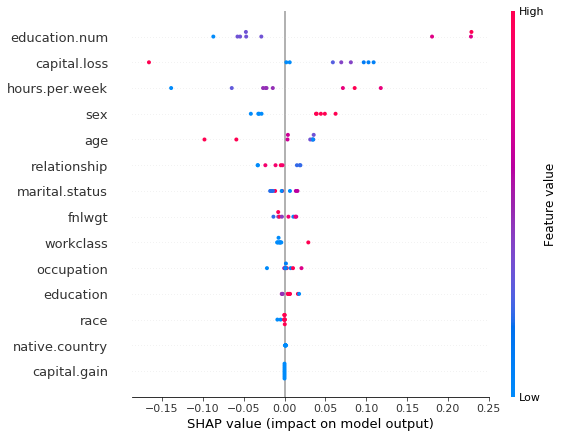

In [518]:
shap.summary_plot(shap_values[1], X_original_test, show = False)
plt.show()

In [519]:
#Encoded Features
explainer = shap.TreeExplainer(clfs_models[1], X_train, model_output = 'probability')
data_point = X_test
shap.initjs()
shap_values = explainer.shap_values(data_point)
shap.force_plot(explainer.expected_value[1], shap_values[1],data_point)

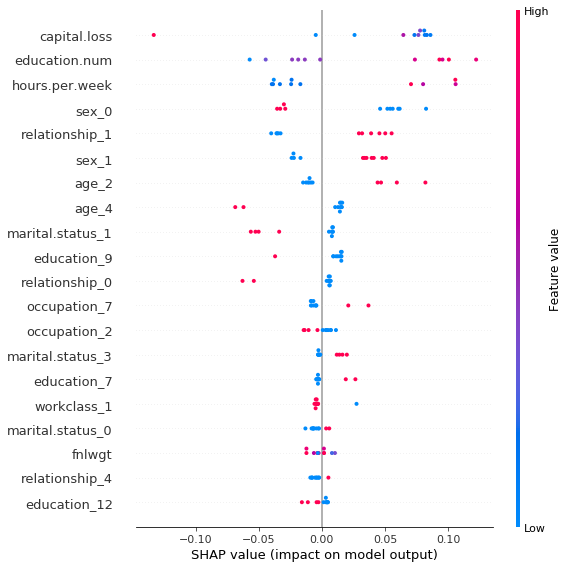

In [520]:
shap.summary_plot(shap_values[1], X_test, show = False)
plt.show()

### Decision Tree on Original and Encoded Features

In [521]:
#Original Features
explainer = shap.TreeExplainer(clfs_models[2], X_original_train, model_output = 'probability')
data_point = X_original_test
shap.initjs()
shap_values = explainer.shap_values(data_point)
shap.force_plot(explainer.expected_value[1], shap_values[1],data_point)

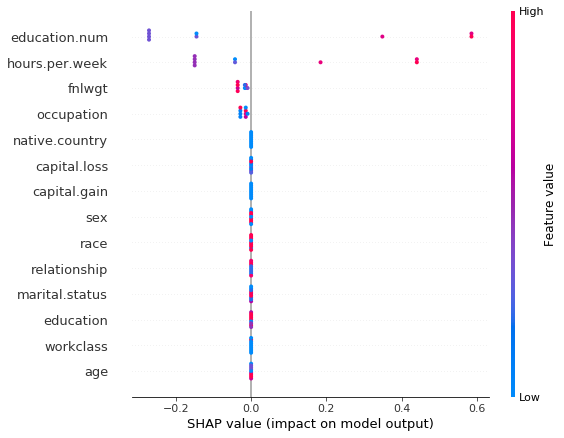

In [522]:
shap.summary_plot(shap_values[1], X_original_test, show = False)
plt.show()

In [523]:
#Encoded Features
explainer = shap.TreeExplainer(clfs_models[3], X_train, model_output = 'probability')
data_point = X_test
shap.initjs()
shap_values = explainer.shap_values(data_point)
shap.force_plot(explainer.expected_value[1], shap_values[1],data_point)

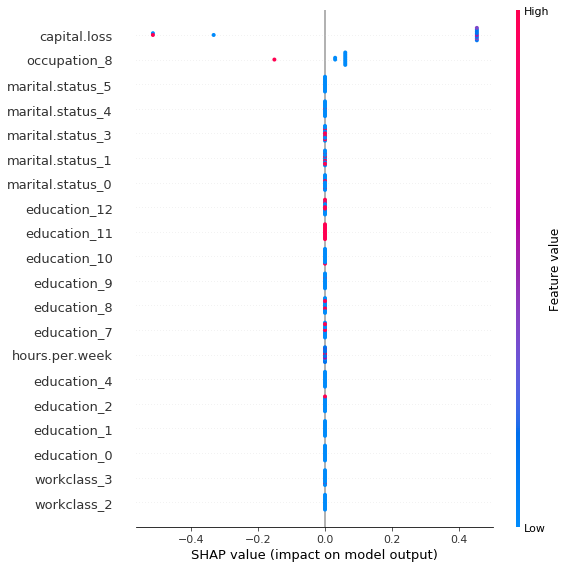

In [524]:
shap.summary_plot(shap_values[1], X_test, show = False)
plt.show()

## (Advanced) Partial Dependence Plots
### Not Implemented (To-Do)
While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

This is useful to answer questions like:

Controlling for all other house features, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?

Are predicted health differences between two groups due to differences in their diets, or due to some other factor?

[Source](https://www.kaggle.com/dansbecker/partial-plots)

# Prepare your submission with your best model
For this dataset, submissions are not allowed because it's not a competition. So, bellow is just shown the standard way of making a kaggle submission.

In [525]:
#Let's prepare a submission of the model that have the best score
"""
copy_4 = average_results[average_results.Model.isin([i[0] for i in models])]
copy_4.sort_values(by=["Test Accuracy"], ascending=False, inplace=True)

best_model_name = copy_4.iloc[0:1,0].values

for clf in every_model:
    if clf[0] == best_model_name:
        predictions = clf[1].predict(X_test)
        break


submission = pd.DataFrame({'Ids':test_ids,'Income':predictions})

submission.to_csv("submission.csv", index=False)

"""

'\ncopy_4 = average_results[average_results.Model.isin([i[0] for i in models])]\ncopy_4.sort_values(by=["Test Accuracy"], ascending=False, inplace=True)\n\nbest_model_name = copy_4.iloc[0:1,0].values\n\nfor clf in every_model:\n    if clf[0] == best_model_name:\n        predictions = clf[1].predict(X_test)\n        break\n\n\nsubmission = pd.DataFrame({\'Ids\':test_ids,\'Income\':predictions})\n\nsubmission.to_csv("submission.csv", index=False)\n\n'

# Making New Predictions

What is the purpose of developing a new ultra optimized model if we can't use it for making predictions on unknown data? Bellow, we'll try to predict the outcome of our model given a new example of entry.

In order to this in an efficient way, it is necessary to make use of pipelines to help us transform or inverse the transformation of the features.

In [558]:
df.iloc[3:5,:]

age workclass  fnlwgt     education  education.num marital.status  \
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation relationship   race     sex  capital.gain  capital.loss  \
3  Machine-op-inspct    Unmarried  White  Female             0          3900   
4     Prof-specialty    Own-child  White  Female             0          3900   

   hours.per.week native.country  
3              40  United-States  
4              40  United-States

In [611]:
Y_train


8370     0
30518    0
10274    0
21101    0
14868    0
        ..
7584     0
2365     1
14539    0
14346    0
25585    0
Name: income, Length: 24420, dtype: int64

In [614]:
# 1) Transform the new data
# 2) Predict
# 3) Reverse the outcome to an Understandable Y label
df = pd.read_csv('adult.csv')
df['income'] = df['income'].map({'>50K': 1, '<=50K': 0})
Y = df['income']
X = df.drop('income',axis=1)

new_data = df.iloc[3:5,:]

bin_transformer = Pipeline(steps = [
    ('binning', KBinsDiscretizer(encode='ordinal'))
])

numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps = [
    ('label', LabelEncoder()),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers = [
        ('bin', bin_transformer, ['age']),
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
        
    ])

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, stratify=Y,random_state=seed)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models[0][1])]) #some previous trained classifier

display(pipeline.fit(X_train, Y_train))
display(X_train.iloc[1,:])

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('bin',
                                                  Pipeline(memory=None,
                                                           steps=[('binning',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=5,
                                                                                    strategy='quantile'))],
                                                           verbose=False),
                                                  ['age']),
                                                 ('num',
                                                  Pipeline

# (Optional Advanced Optimization 1) Iterations of Feature Selection/Feature Creation 

- Deep Feature Synthesis - [Source](https://www.kaggle.com/willkoehrsen/featuretools-for-good)
    - Min, max, etc
    - Squared, Cubed, etc
- Combination of Features
- Clustering, t-SNE, etc

In [527]:
#Implementation for Deep Feature Synthesis
"""
for col in X.columns:
    feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = col, 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = ['divide'], drop_contains = list(all_features),
                                       max_depth = 2, max_features = 100,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 1000)


    all_features += [str(x.get_name()) for x in feature_names_add]
    X = pd.concat([X, feature_matrix_add], axis = 1)
"""
#Next it is important to do all the pre processing again before training/testing the model. 
#Many iterations of Feature Creation and Selection might be needed to improve the model a little bit.

"\nfor col in X.columns:\n    feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = col, \n                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',\n                                                         'sum', 'skew', 'std', range_, pcorr_],\n                                       trans_primitives = ['divide'], drop_contains = list(all_features),\n                                       max_depth = 2, max_features = 100,\n                                       verbose = 1, n_jobs = -1, \n                                       chunk_size = 1000)\n\n\n    all_features += [str(x.get_name()) for x in feature_names_add]\n    X = pd.concat([X, feature_matrix_add], axis = 1)\n"

# (Optional Advanced Optimization 2) More Alternative Methods to Feature Selection

The following methods are adapted to our dataset but the parameters are not optimized at all, it lacks deeper tuning and insights.

## Filter Method - the most easy and naive method

In [528]:
"""
#Filter Method - easiest but not the best way
print(X[["sex","age"]].corr())

X = X.drop('sex',axis=1)
"""

'\n#Filter Method - easiest but not the best way\nprint(X[["sex","age"]].corr())\n\nX = X.drop(\'sex\',axis=1)\n'

## FORWARD SELECTION (wrapper method 2)

Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

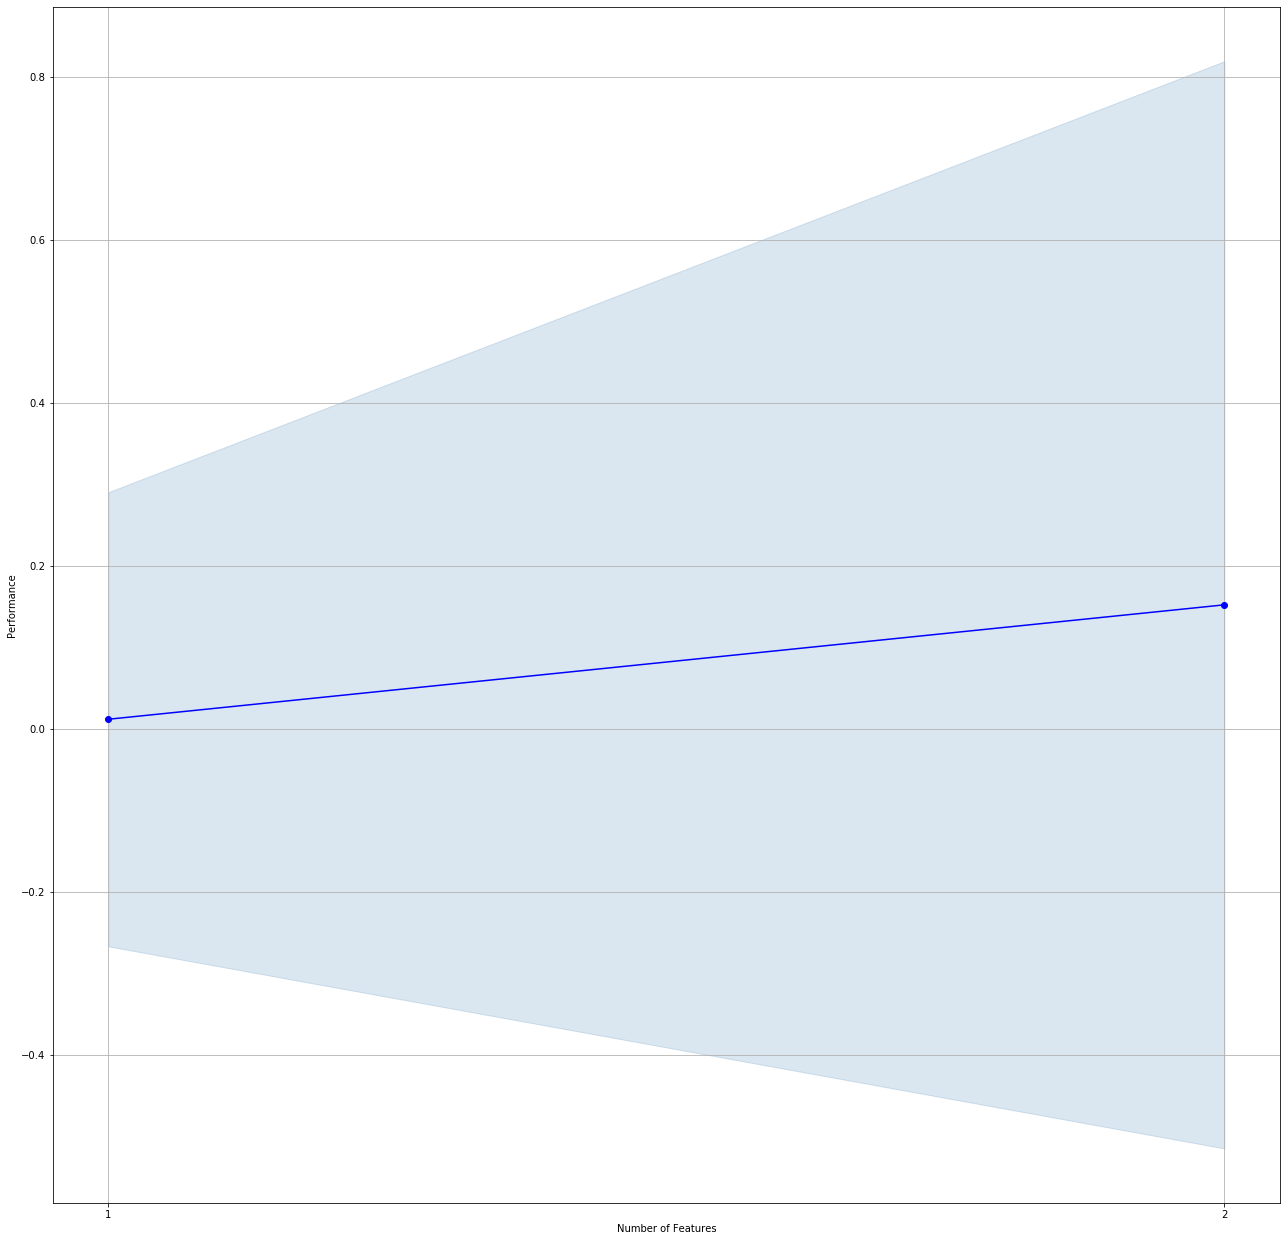

('age_4', 'education.num')


In [529]:
sfs1 = sfs(LinearRegression(), k_features=len(X.columns) , forward=True , scoring='r2')
sfs1 = sfs1.fit(X,Y)
plot_sfs(sfs1.get_metric_dict(), figsize=(22,22))
plt.grid(True)
plt.show()

print(sfs1.k_feature_names_)

In [530]:
"""
constant = 2
sfs1 = sfs(LinearRegression() , k_features=constant , forward=True , scoring='r2')
sfs1 = sfs1.fit(X_train,Y_train)
sfs1.k_feature_names_

lr=LinearRegression().fit(X_train,Y_train)
y_pred_fs=lr.predict(X_test)
r2_score(Y_test,y_pred_fs)
"""

"\nconstant = 2\nsfs1 = sfs(LinearRegression() , k_features=constant , forward=True , scoring='r2')\nsfs1 = sfs1.fit(X_train,Y_train)\nsfs1.k_feature_names_\n\nlr=LinearRegression().fit(X_train,Y_train)\ny_pred_fs=lr.predict(X_test)\nr2_score(Y_test,y_pred_fs)\n"

## RECURSIVE ELIMINATION (wrapper method 3)

It is a greedy optimization algorithm which aims to find the best performing feature subset. It repeatedly creates models and keeps aside the best or the worst performing feature at each iteration. It constructs the next model with the left features until all the features are exhausted. We need to find the optimum number of features, 
for which the accuracy is the highest. It then ranks the features based on the order of their elimination.

[Source](https://github.com/skeitel/Artificial-Intelligence-Deep-Learning-Machine-Learning-by-Javier-Marti/blob/4ac3c27813ae17f395d169ec2a0e8bb111edbf61/MASTER_EDA_Machine_Learning.ipynb)

In [531]:
nof_list=np.arange(1,len(df.columns)+1)            
high_score=0

nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Best number of features: %d" %nof)
print("Score Obtained with %d features: %f" % (nof, high_score))

ValueError: Found input variables with inconsistent numbers of samples: [33, 30]

In [ ]:
#Now that we now the perfect number of features, we feed them to a RFE and get the final set of features
cols = list(X.columns)
model = LogisticRegression()

rfe = RFE(model, nof)             

X_rfe = rfe.fit_transform(X,Y)  

model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

#to apply the reduction
#X = X[selected_features_rfe] 

print(rfe.support_)
print(rfe.ranking_)

## FEATURE SELECTION - EMBEDDED METHOD

In [ ]:
reg = LassoCV()
reg.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,Y))
coef = pd.Series(reg.coef_, index = X.columns)

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

## Using SelectKBest (chi2)
[Source](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e)

In [ ]:
"""
constant=2
bestfeatures = SelectKBest(score_func=chi2, k=constant)

fit = bestfeatures.fit(X,np.ravel(Y)) #X can't have negative values, it can't be standardized
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features
"""

## Using Extra Trees Classifier

In [ ]:
constant = 10
clf = ExtraTreesClassifier()
clf.fit(X,Y)
print(clf.feature_importances_)
feature_importances = pd.Series(clf.feature_importances_, index = X.columns).nlargest(constant).plot(kind = 'barh')
print(feature_importances)
plt.show()

## Using Recursive Feature Elimination with Cross Validation

In [ ]:
model = RFECV(RandomForestClassifier(), scoring = 'accuracy').fit(X,Y)
model.score(X,Y)

## Using SelectFromModel and SVC

In [ ]:
model = SelectFromModel(LinearSVC(C=0.01, penalty='l1', dual=False)).fit(X, Y).transform(X)

## Using Example of SelectFromModel

In [ ]:
folds = 5
model = SelectFromModel(LassoCV(cv = folds))
model.fit(X,Y).transform(X)